### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import os
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import torchvision
from torchvision import models
from apex import amp

from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensorV2, ToTensor

from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

import cv2
import skimage.io
import IPython.display as display
from PIL import Image

plt.ion()
%matplotlib inline
%config InlineBackend.figure_format='retina'

#### Local Imports

In [115]:
# Paths
from chestxray.config import (PANDA_PATH,
                              MODEL_PATH,
                              PANDA_IMGS,
                              PANDA_MASKS,
                              TRAIN_CSV)
# Competition related config
from chestxray.config import CFG

# Misc
from chestxray.misc import seed_torch

# Datasets
from chestxray.datasets import get_transforms, TrainDataset, ZeroDataset

# Viz
from chestxray.visualize import (show_from_ids, show_batch, imshow, 
                                 plot_classes_preds, reverse_show_img, 
                                 plot_confusion_matrix)

# Nets
from chestxray.nets import TinyV2ConvNet, make_RN50_cls
from chestxray.model_utils import trainable_params, cce_loss_at_init, check_final_linear_bias_init

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
print(torch.cuda.get_device_properties(device))

_CudaDeviceProperties(name='GeForce RTX 2070 SUPER', major=7, minor=5, total_memory=7979MB, multi_processor_count=40)


### Config

In [11]:
# This notebook is debug only (to check all moving parts make sense)
CFG.debug = True

### Fix Random Seed

In [14]:
seed_torch()

#### Define Debug Writer

In [67]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/debug')

### Load Data

In [15]:
TRAIN_DF = pd.read_csv(TRAIN_CSV)
TRAIN_DF.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


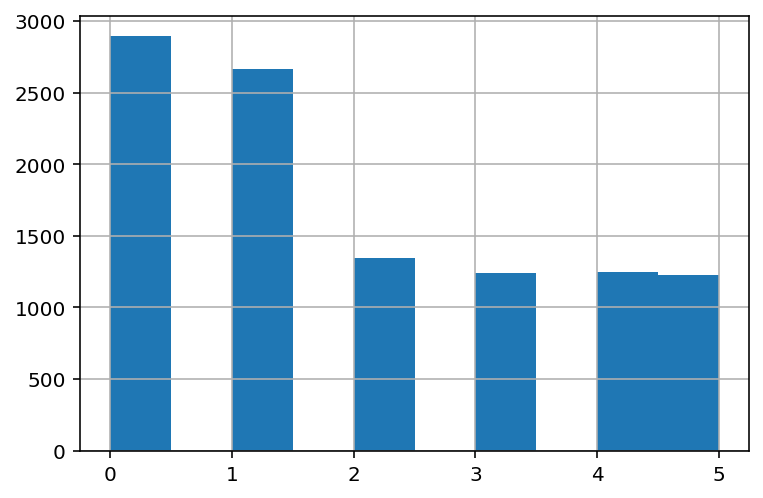

In [16]:
_ = TRAIN_DF[CFG.target_col].hist()

In [17]:
if CFG.debug:
    train = TRAIN_DF.sample(n=500, random_state=CFG.seed).reset_index(drop=True).copy()
else:
    train = TRAIN_DF.copy()

### Pytorch Datasets and Dataloaders

#### Datasets Sanity Check

In [19]:
debug_dataset = TrainDataset(train, transform=get_transforms(data="train"), debug=True)
debug_loader = DataLoader(debug_dataset, batch_size=CFG.batch_size, 
                          shuffle=False, num_workers=8,)

In [20]:
imgs, lbls, ids = next(iter(debug_loader))

In [21]:
print(f"Images: {imgs.shape, imgs.dtype}.")
print(f"Labels: {lbls.shape, lbls.dtype}.")

Images: (torch.Size([32, 3, 256, 256]), torch.float32).
Labels: (torch.Size([32]), torch.int64).


In [22]:
# sanity check for shuffle
all(train.loc[train[CFG.img_id_col] == img_id, CFG.target_col].values[0] == label
       for img_id, label in zip(ids, lbls.numpy()))

True

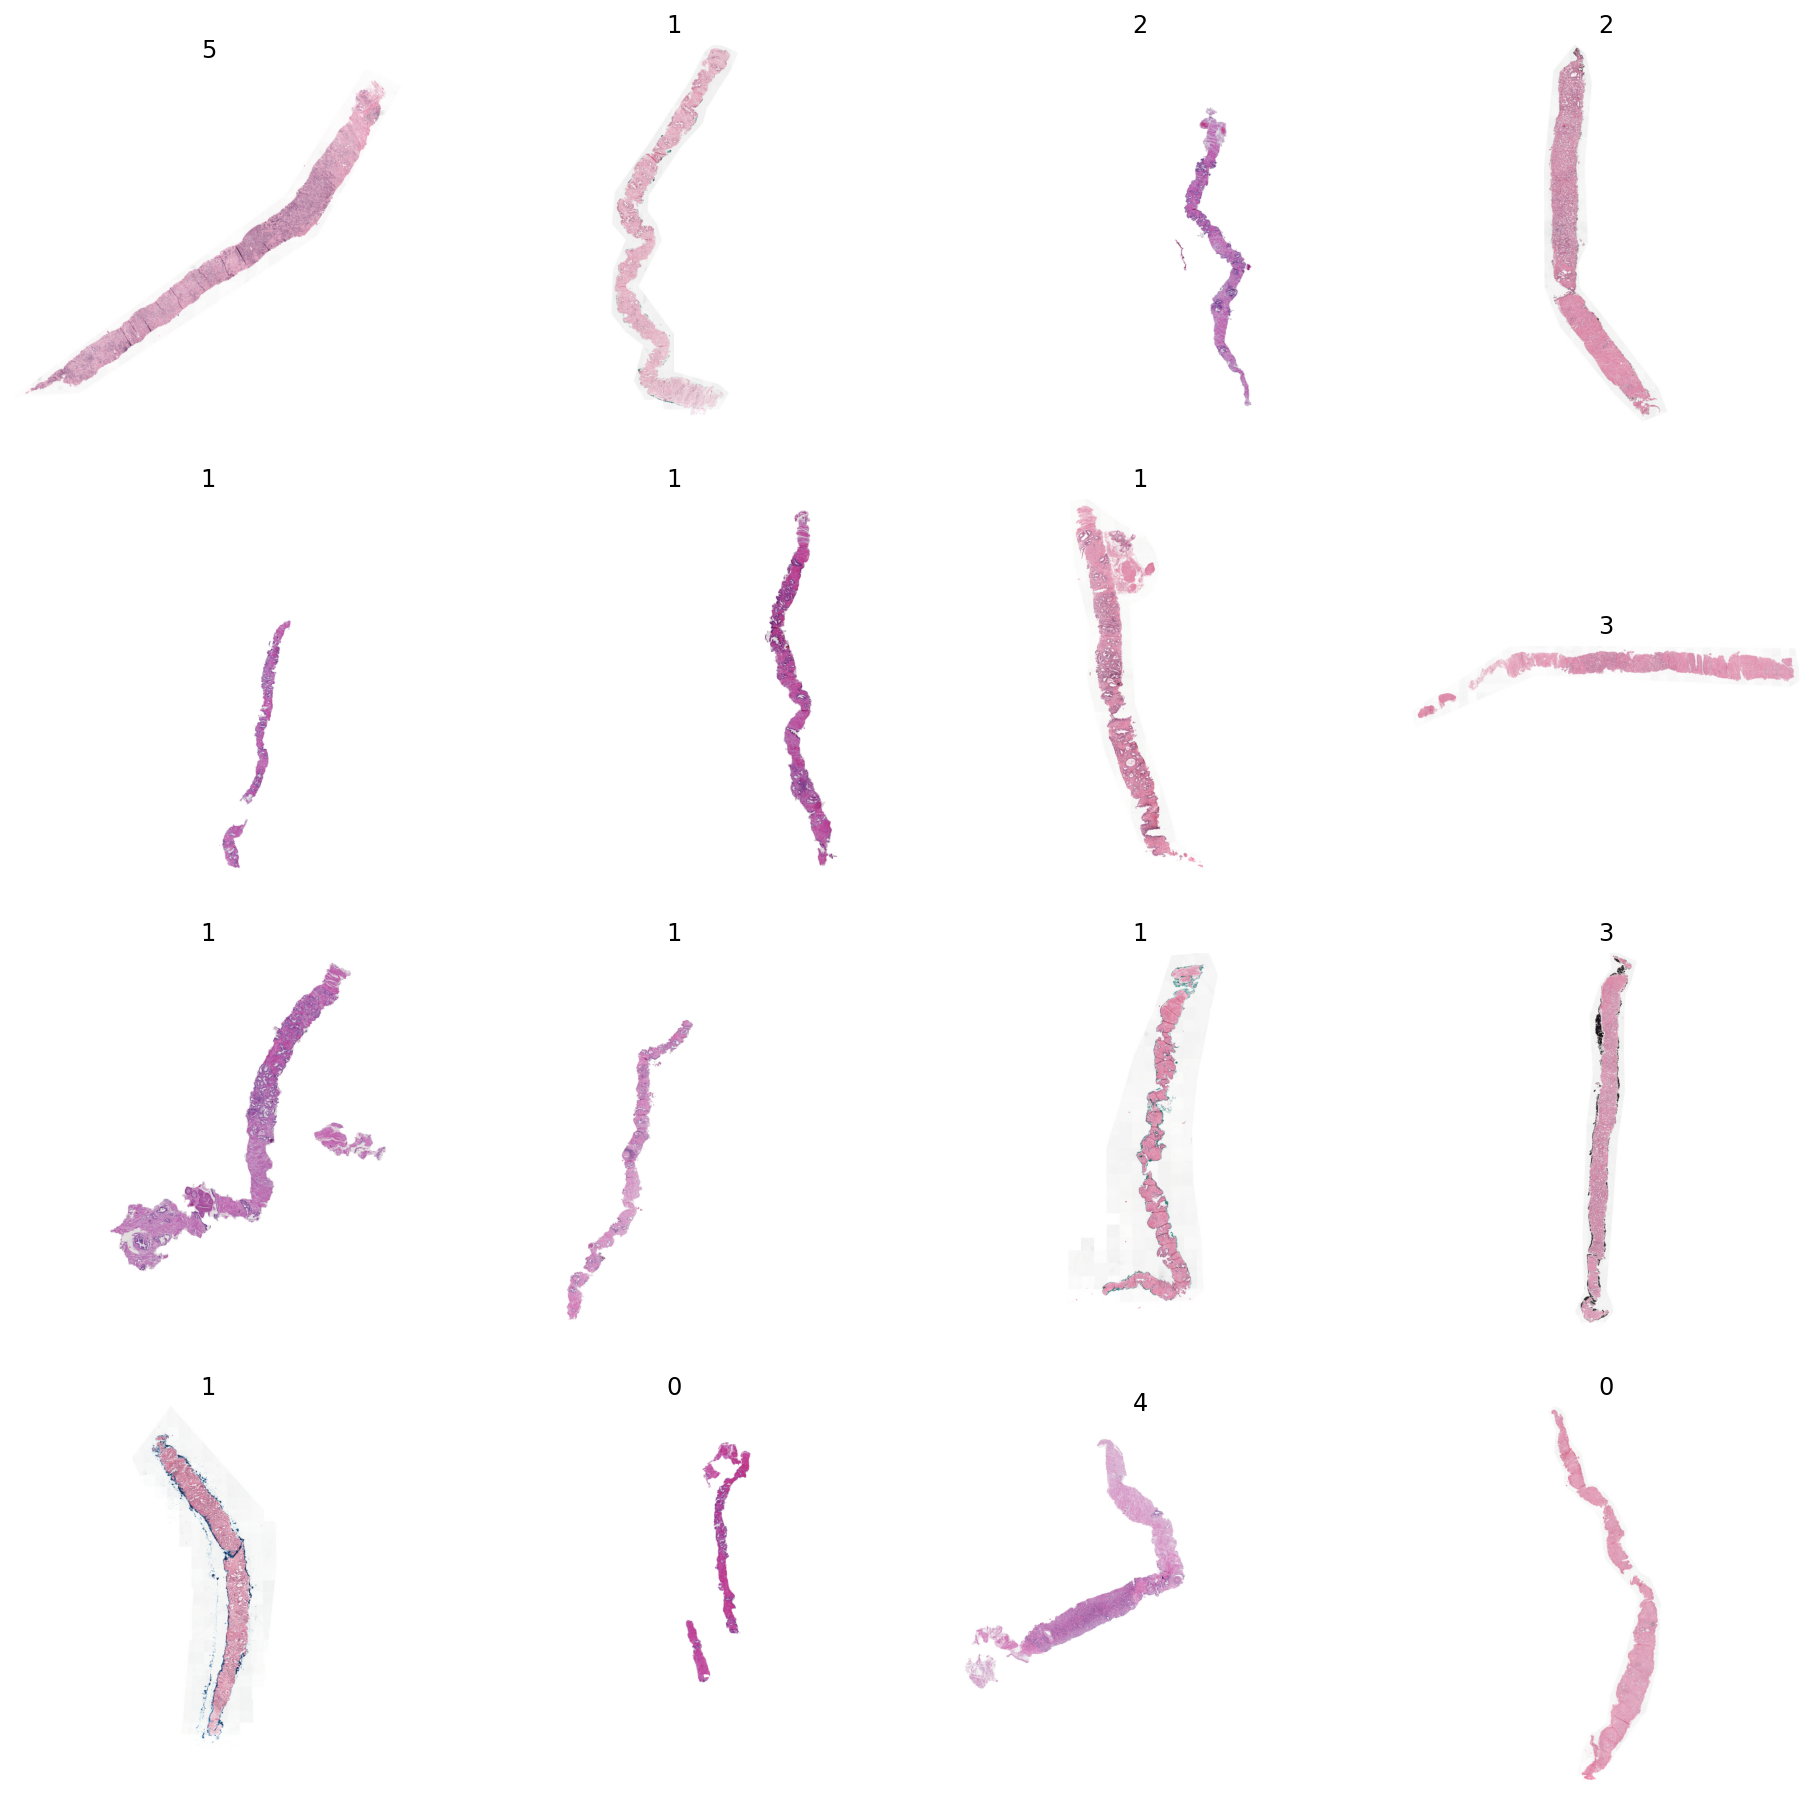

In [29]:
show_from_ids(ids, train)

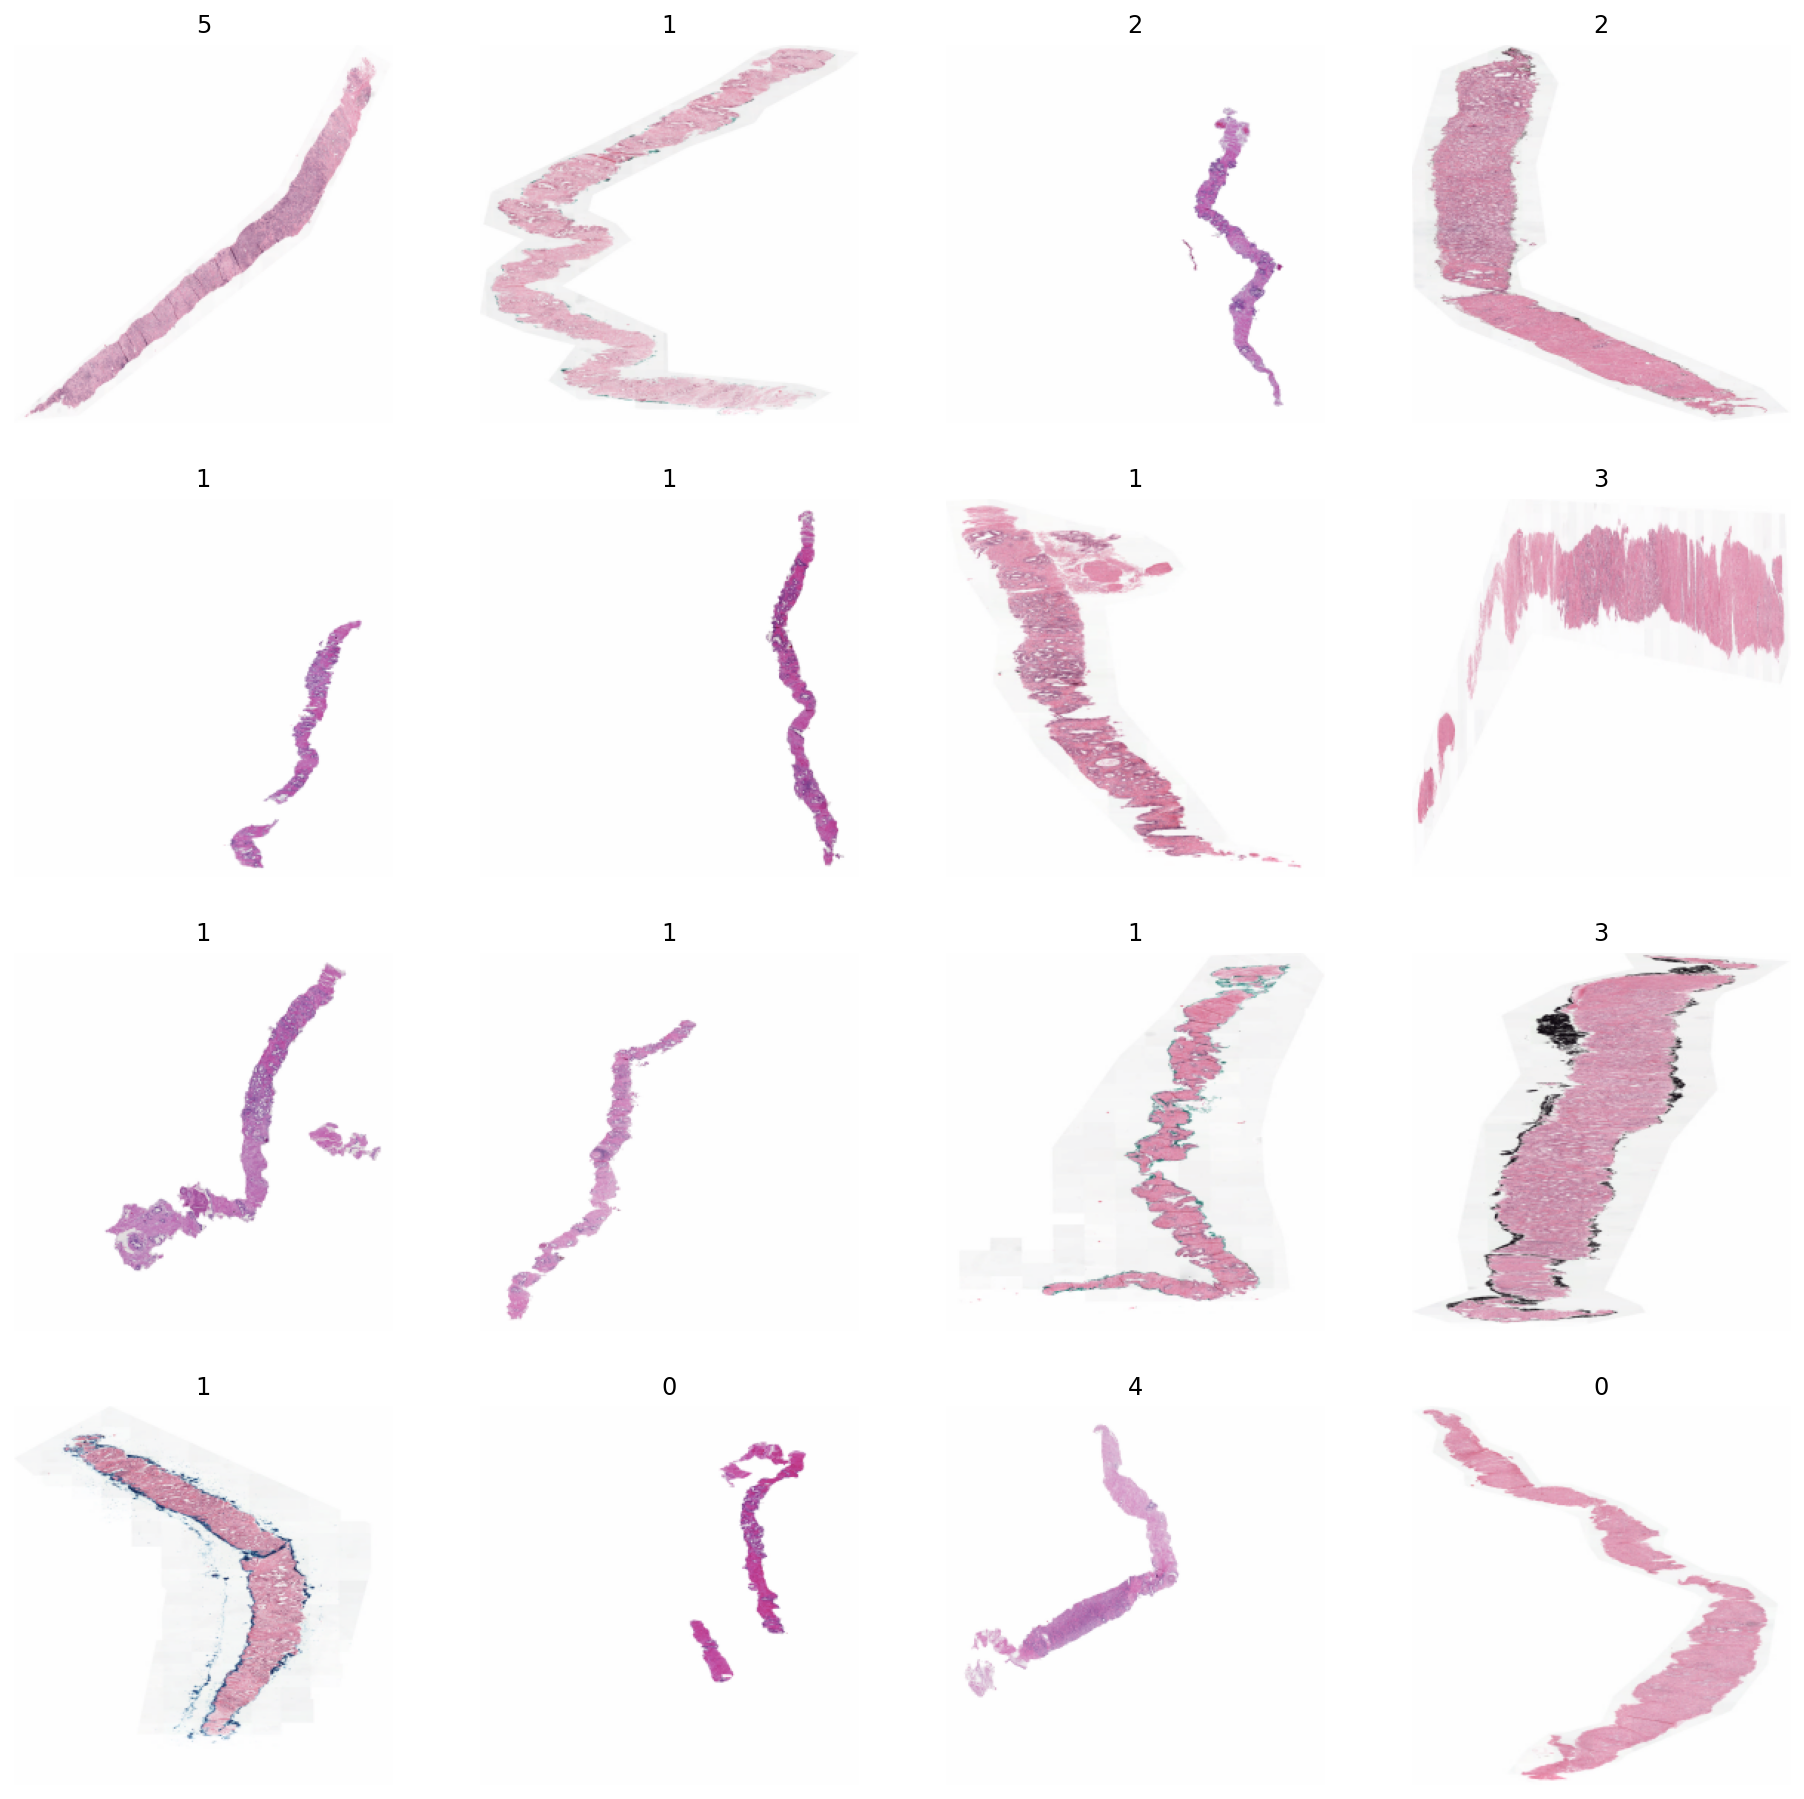

In [56]:
# Show reversed tensor batch
show_batch(imgs, lbls)

### Model Sanity Check

In [33]:
model = TinyV2ConvNet(num_classes=CFG.target_size)

In [34]:
print(model)

TinyV2ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), st

In [37]:
trainable_params(model)

Model has: 1080582 trainable parameters


#### Loss @ Init

In [42]:
cce_loss_at_init(model, 6)

CCE loss @ init: 1.7844021320343018 -- -log(1/6 classes): 1.791759469228055


#### Correct Bias Init Check

In [45]:
# init well - set bias to predict inbalanced class probabilities
cls_probas = (TRAIN_DF[CFG.target_col].value_counts() / len(TRAIN_DF)).values
# should init output layer bias like this 
out_layer_bias = np.log(cls_probas)

In [46]:
model = TinyV2ConvNet(CFG.target_size)

In [48]:
check_final_linear_bias_init(model, cls_probas)

Class probabilities:
 [0.27241899 0.25113037 0.12650716 0.1176526  0.11699322 0.11529766]
Softmax on output logits:
 tensor([[0.2602, 0.2566, 0.1269, 0.1328, 0.1103, 0.1132],
        [0.2603, 0.2565, 0.1271, 0.1328, 0.1102, 0.1131],
        [0.2602, 0.2565, 0.1271, 0.1328, 0.1105, 0.1130],
        [0.2602, 0.2565, 0.1271, 0.1327, 0.1104, 0.1130],
        [0.2604, 0.2565, 0.1270, 0.1328, 0.1103, 0.1130]])


#### Tensorbord Writer and Visualisations

In [52]:
model = models.resnet18(pretrained=False)

In [53]:
conv1_weight = model.conv1.weight.data
img_grid = torchvision.utils.make_grid(conv1_weight, normalize=True)

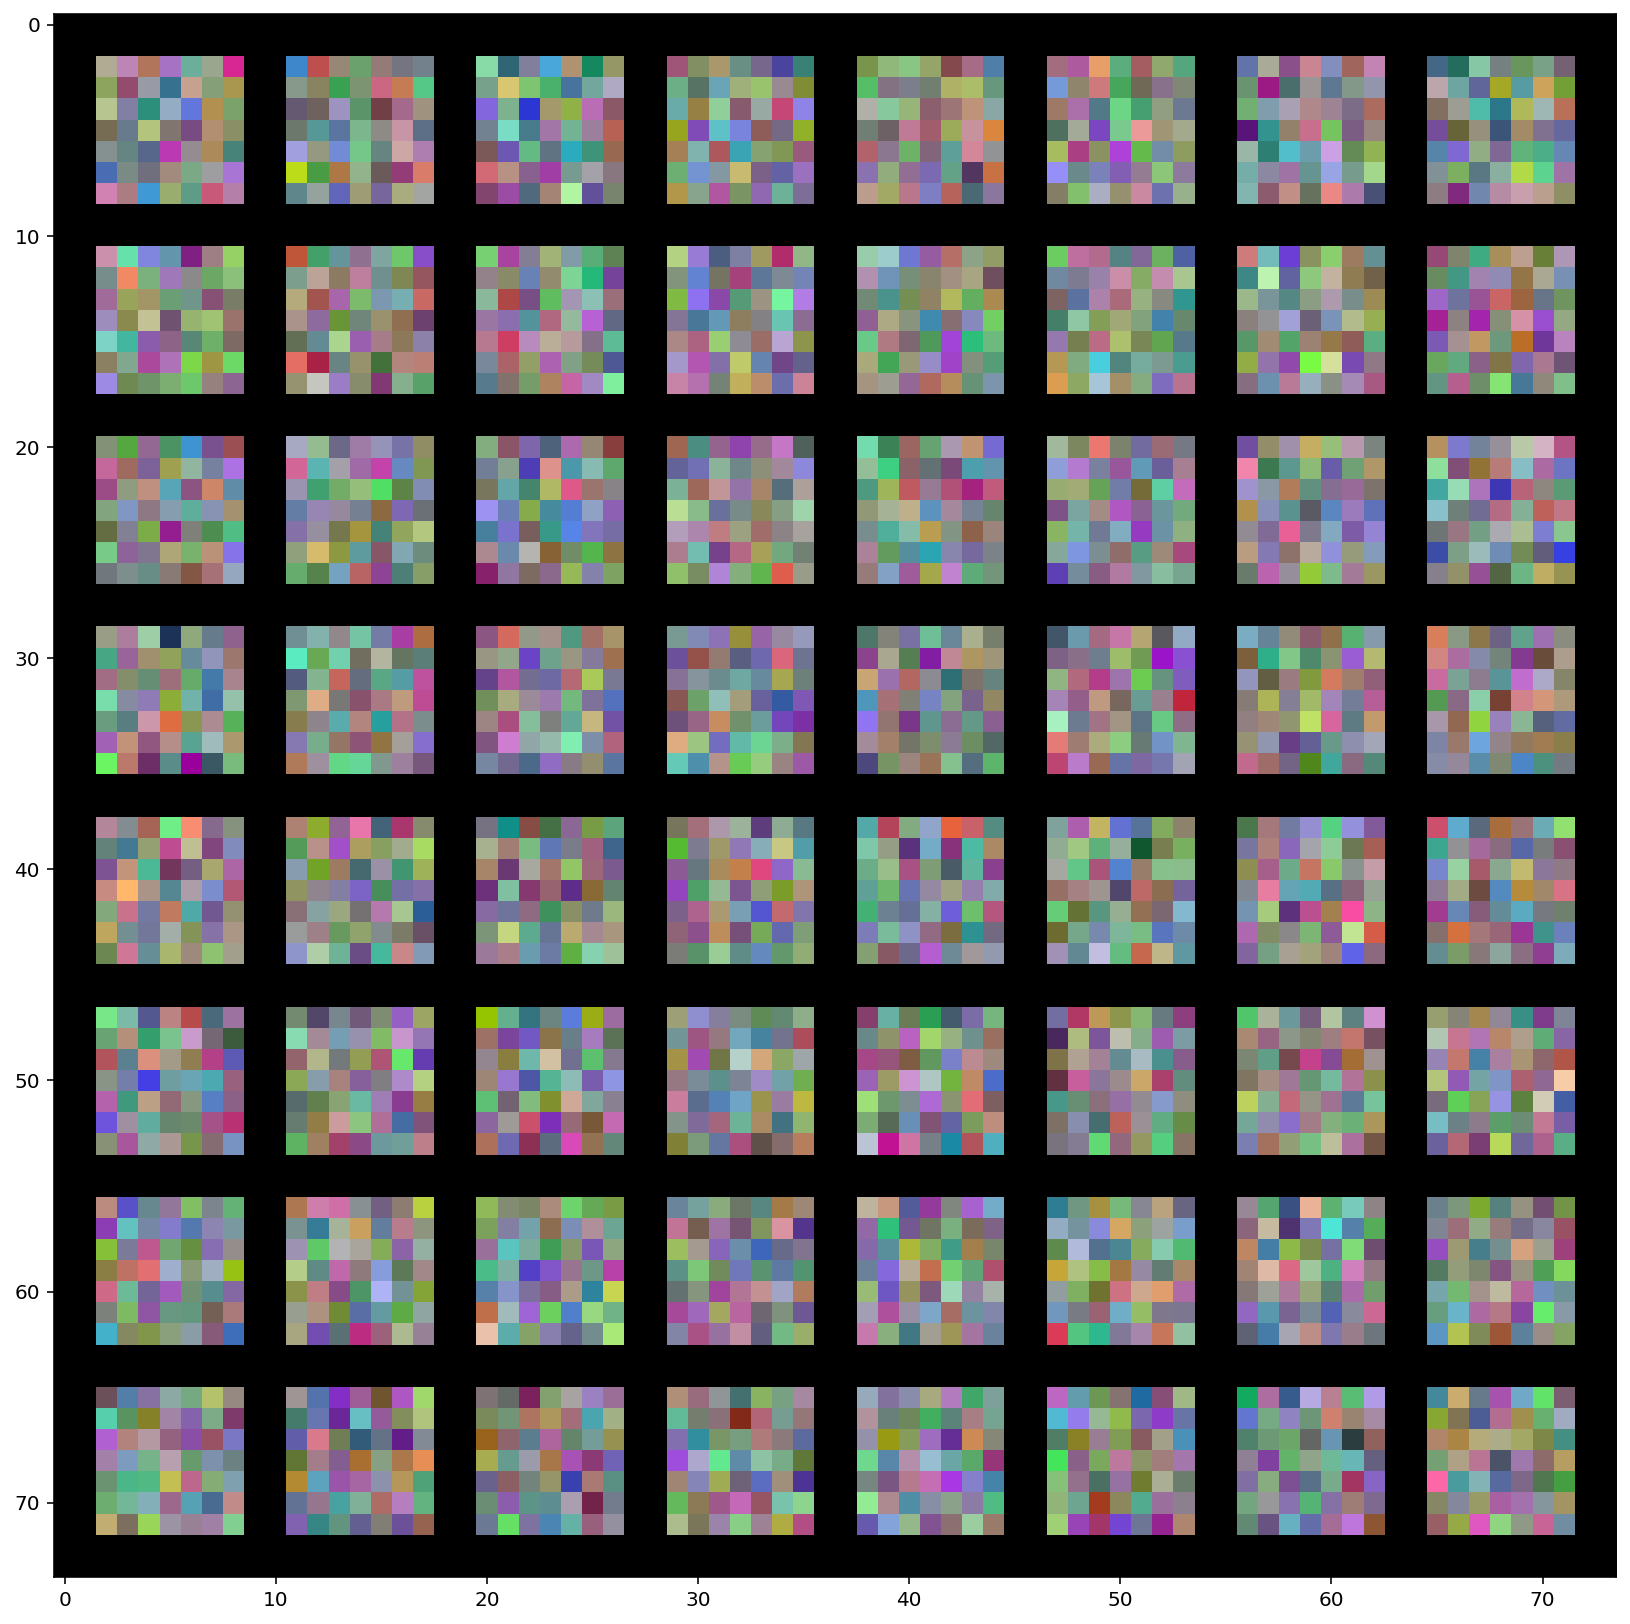

In [54]:
imshow(img_grid)

In [58]:
tin_model = TinyV2ConvNet(CFG.target_size)
tin_model.eval();
output = tin_model(imgs)

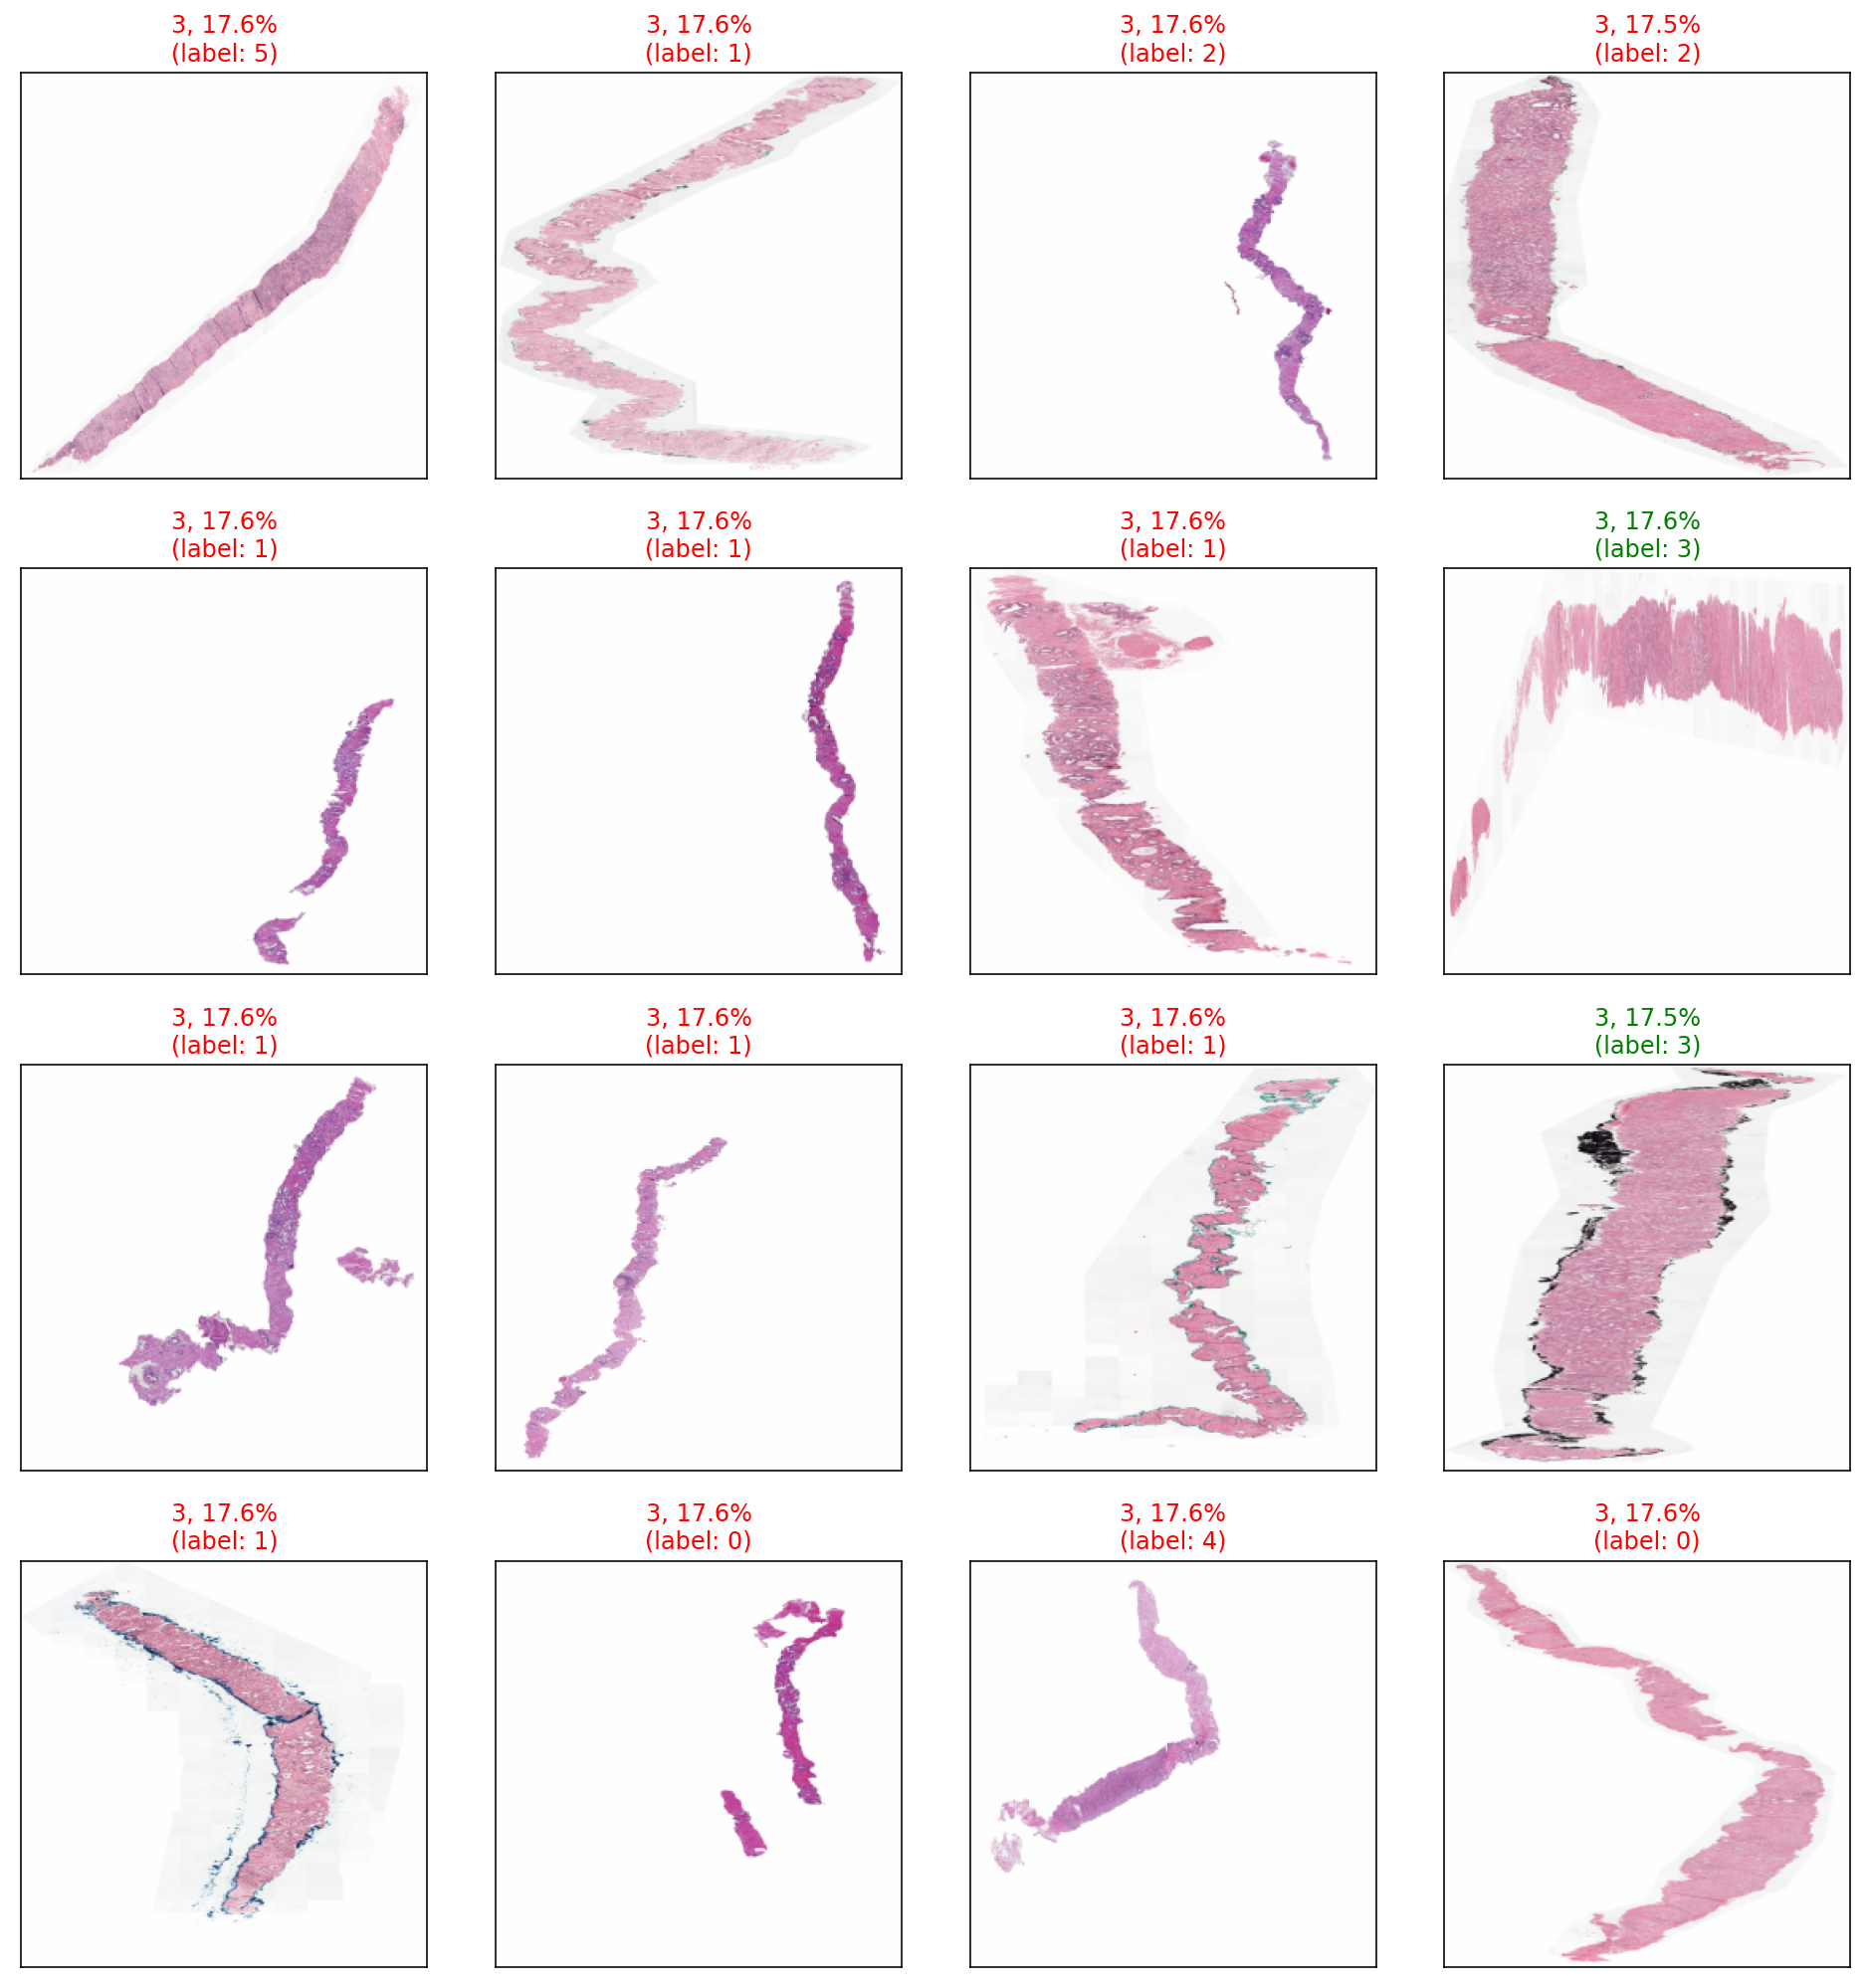

In [61]:
_ = plot_classes_preds(output, imgs, lbls)

#### Input-Indepent Baseline

In [80]:
def train_only(dataset, model, optimizer, criterion, batch_sz=CFG.batch_size, num_epochs=25):
    # define a data loader
    dataloader = DataLoader(dataset, batch_size=batch_sz, shuffle=True, num_workers=6)
    model.to(device)
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        running_loss = 0.0
        # create random step
        rand_step = np.random.randint(0, len(dataloader))
        epoch_preds = []
        epoch_labels = []
        # Iterate over data.
        tk_train = tqdm(enumerate(dataloader), total=len(dataloader))
        for i, data in tk_train:
            # Calculate global step
            glob_step = epoch * len(dataloader) + i
            # Set training mode
            model.train();
            inputs, labels = data
            # Visualize input to the model:
            if i == rand_step:
                img = reverse_show_img(inputs[0])
                writer.add_image(tag="Input Image", img_tensor=img, 
                                 global_step=glob_step, dataformats="HWC")
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # loss is mean across batch, multiply by batch size
            # divide by number of steps in epoch (so loss is normalized)
            running_loss += loss.item() / len(dataloader)
            # tensorboard
            writer.add_scalar(tag="Training loss", scalar_value=loss.item(), 
                              global_step=glob_step)
            
            # collect preds and labels for QWK
            epoch_preds.append(outputs.data.to('cpu').numpy().argmax(1))
            epoch_labels.append(labels.to('cpu').numpy())
        
        epoch_loss = running_loss
        print(f'Loss: {epoch_loss:.4f}')
        
        # Calculate epoch QWK and preds distribution
        epoch_preds = np.concatenate(epoch_preds)
        epoch_labels = np.concatenate(epoch_labels)
        print(f'Counter preds: {Counter(epoch_preds)}')
        qwk = cohen_kappa_score(epoch_preds, epoch_labels, weights='quadratic')
        print(f"Epoch QWK: {qwk:.3f}")
        writer.add_scalar(tag="Training QWK", scalar_value=qwk, 
                              global_step=epoch)
        
        # write imgs and predictions to the Tensorboard
        # it is last batch
        with torch.no_grad():
            model.eval();
            output = model(inputs)
            output = output.to("cpu")
            inputs = inputs.to("cpu")
            labels = labels.to("cpu")
            writer.add_figure(tag="Actuals vs Predictions", 
                              figure=plot_classes_preds(output, inputs, labels), 
                              global_step=glob_step)
            
    writer.close()

In [71]:
zero_ds = ZeroDataset(500)
zero_loader = DataLoader(zero_ds, batch_size=CFG.batch_size, num_workers=6)

In [72]:
model = TinyV2ConvNet(CFG.target_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr, amsgrad=False)

In [73]:
# It is not working with ZeroDataset
train_only(zero_ds, model, optimizer, criterion, num_epochs=5)

Epoch 0/4
----------


100%|██████████| 16/16 [00:02<00:00,  7.27it/s]


Loss: 1.7911
Counter preds: Counter({1: 500})
Epoch QWK: 0.000
Epoch 1/4
----------


100%|██████████| 16/16 [00:02<00:00,  7.29it/s]


Loss: 1.7930
Counter preds: Counter({5: 224, 0: 128, 1: 96, 4: 32, 2: 20})
Epoch QWK: 0.010


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f64d42058c0>
Traceback (most recent call last):
  File "/home/ademyanchuk/.cache/pypoetry/virtualenvs/chestxray-uNc73CMC-py3.7/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/ademyanchuk/.cache/pypoetry/virtualenvs/chestxray-uNc73CMC-py3.7/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/home/ademyanchuk/.pyenv/versions/3.7.7/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/home/ademyanchuk/.pyenv/versions/3.7.7/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/home/ademyanchuk/.pyenv/versions/3.7.7/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


Epoch 2/4
----------


100%|██████████| 16/16 [00:02<00:00,  7.26it/s]


Loss: 1.8484
Counter preds: Counter({5: 256, 1: 96, 2: 64, 4: 64, 0: 20})
Epoch QWK: -0.055
Epoch 3/4
----------


100%|██████████| 16/16 [00:02<00:00,  7.18it/s]


Loss: 1.8001
Counter preds: Counter({5: 340, 0: 160})
Epoch QWK: -0.081
Epoch 4/4
----------


100%|██████████| 16/16 [00:02<00:00,  7.58it/s]


Loss: 1.7963
Counter preds: Counter({5: 500})
Epoch QWK: 0.000


#### Overfit One Batch

In [81]:
if CFG.debug:
    train = TRAIN_DF.sample(n=6, random_state=CFG.seed).reset_index(drop=True).copy()

In [82]:
one_batch_ds = TrainDataset(train, transform=get_transforms(data="train"), debug=False)

In [83]:
model = TinyV2ConvNet(CFG.target_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr, amsgrad=False)

In [84]:
CFG.batch_size = 6

In [85]:
train_only(one_batch_ds, model, optimizer, criterion, num_epochs=100)

Epoch 0/99
----------


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


Loss: 1.7570
Counter preds: Counter({0: 6})
Epoch QWK: 0.000
Epoch 1/99
----------


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


Loss: 1.3315
Counter preds: Counter({1: 5, 2: 1})
Epoch QWK: 0.118
Epoch 2/99
----------


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


Loss: 1.1113
Counter preds: Counter({1: 5, 2: 1})
Epoch QWK: 0.118
Epoch 3/99
----------


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Loss: 0.9481
Counter preds: Counter({1: 5, 2: 1})
Epoch QWK: 0.118
Epoch 4/99
----------


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


Loss: 0.8177
Counter preds: Counter({1: 4, 5: 1, 2: 1})
Epoch QWK: 0.857
Epoch 5/99
----------


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


Loss: 0.6995
Counter preds: Counter({1: 4, 5: 1, 2: 1})
Epoch QWK: 0.857
Epoch 6/99
----------


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Loss: 0.5998
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 7/99
----------


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


Loss: 0.5184
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 8/99
----------


  0%|          | 0/1 [00:00<?, ?it/s]


KeyboardInterrupt: 

### Train Eval Loop

In [107]:
def train_eval_loop(train_dataset, val_dataset, model, optimizer, criterion, batch_sz=CFG.batch_size, num_epochs=CFG.epoch, tb_tag="", model_name="debug"):
    # Write first layer weights to TB
    if not CFG.debug:
        conv1_weight = model.conv1.weight.data.to("cpu")
        img_grid = torchvision.utils.make_grid(conv1_weight, normalize=True)
        writer.add_image(tag=f"Model conv1 weights {tb_tag}", img_tensor=img_grid, global_step=0)
    
    # define a data loader
    train_dataloader = DataLoader(train_dataset, batch_size=batch_sz, shuffle=True, num_workers=6)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_sz, shuffle=False, num_workers=4)
    model.to(device)
    if CFG.use_amp:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1")
    
#     scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True, eps=1e-6)
#     scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    # Define epochs numbers to look into input images and predictions
    # No more than 10 times per full training
    vis_step = np.ceil(num_epochs/10).astype(int)
    visual_epochs = list(range(0, num_epochs, vis_step))
    
#     best_qwk = -100
    best_val_loss = np.inf
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        # Training Phase
        # Set training mode
        model.train();
        train_running_loss = 0.0
        train_epoch_preds, train_epoch_labels = [], []
        # create random step
        rand_step = np.random.randint(0, len(train_dataloader))
        
        # Iterate over train data.
        tk_train = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        for i, data in tk_train:
            # Calculate global step
            train_global_step = epoch * len(train_dataloader) + i
            
            inputs, labels = data
            # Visualize input to the model:
            if epoch in visual_epochs and i == rand_step:
                img = reverse_show_img(inputs[0])
                writer.add_image(tag=f"Input Image {tb_tag}", img_tensor=img, global_step=train_global_step, dataformats="HWC")
                del img
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            if CFG.use_amp:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            optimizer.step()
            # loss is mean across batch, multiply by batch size
            # divide by number of steps in epoch (so loss is normalized)
            train_running_loss += loss.item() / len(train_dataloader)
            # tensorboarding loss
            writer.add_scalar(tag=f"Training loss {tb_tag}", scalar_value=loss.item(), global_step=train_global_step)
            
            # collect train preds and labels for QWK
            train_epoch_preds.append(outputs.data.to('cpu').numpy().argmax(1))
            train_epoch_labels.append(labels.to('cpu').numpy())
        
        # Validation Phase
        # Set evaluation mode
        model.eval();
        val_running_loss = 0.0
        val_epoch_preds, val_epoch_labels = [], []
        # Iterate over val data
        tk_val = tqdm(enumerate(val_dataloader), total=len(val_dataloader))
        for j, data in tk_val:
            # Calculate global step
            val_global_step = epoch * len(val_dataloader) + j
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() / len(val_dataloader)
            # tensorboarding loss
            writer.add_scalar(tag=f"Validation loss {tb_tag}", scalar_value=loss.item(), global_step=val_global_step)
            
            # collect validation preds and labels for QWK
            val_epoch_preds.append(outputs.data.to('cpu').numpy().argmax(1))
            val_epoch_labels.append(labels.to('cpu').numpy())
            
            # visualise predictions for 0th validation batch
            if epoch in visual_epochs and j == 0:
                writer.add_figure(tag=f"Actuals vs Predictions {tb_tag}", figure=plot_classes_preds(outputs.to('cpu'), inputs.to('cpu'), labels.to('cpu')), 
                                  global_step=val_global_step)
        
#         scheduler.step()
        # "End of Epoch" Phase
        print(f'Training Loss: {train_running_loss:.4f}\tValidation Loss: {val_running_loss:.4f}')
        
        # Calculate epoch QWK and preds distribution
        train_epoch_preds = np.concatenate(train_epoch_preds)
        train_epoch_labels = np.concatenate(train_epoch_labels)
        val_epoch_preds = np.concatenate(val_epoch_preds)
        val_epoch_labels = np.concatenate(val_epoch_labels)
        print(f'Counter train preds: {Counter(train_epoch_preds)}\tCounter val preds: {Counter(val_epoch_preds)}')
        
        train_qwk = cohen_kappa_score(train_epoch_preds, train_epoch_labels, weights='quadratic')
        val_qwk = cohen_kappa_score(val_epoch_preds, val_epoch_labels, weights='quadratic')
        print(f"Epoch train QWK: {train_qwk:.3f}\tval QWK: {val_qwk:.3f}")
        writer.add_scalar(tag=f"Training QWK {tb_tag}", scalar_value=train_qwk, global_step=epoch)
        writer.add_scalar(tag=f"Validation QWK {tb_tag}", scalar_value=val_qwk, global_step=epoch)
        
        # On the best val loss do:
        if val_running_loss < best_val_loss:
            # update best and save model
            best_val_loss = val_running_loss
            print(f'  Epoch {epoch} - Save Best Loss: {best_val_loss:.4f} Model')
            torch.save(model.state_dict(), f'{MODEL_PATH}/{model_name}.pth')
            
            # add losses as text to TB
            writer.add_text("On save:", 
                            f"tr_loss: {train_running_loss:.4f}, tr_qwk: {train_qwk:.4f}, val_loss: {val_running_loss:.4f}, val_qwk: {val_qwk:.4f}",
                            global_step=train_global_step)
            
            # add image of conv1 weights to TB
            if not CFG.debug:
                conv1_weight = model.conv1.weight.data.to("cpu")
                img_grid = torchvision.utils.make_grid(conv1_weight, normalize=True)
                writer.add_image(tag=f"Model conv1 weights {tb_tag}", img_tensor=img_grid, global_step=train_global_step)
            
            # add confusion matrix to TB
            writer.add_figure(tag=f"Confusion matrix {tb_tag}", figure=plot_confusion_matrix(val_epoch_labels, val_epoch_preds), 
                                  global_step=val_global_step)
    
    writer.close()

In [108]:
if CFG.debug:
    train = TRAIN_DF.sample(n=6, random_state=CFG.seed).reset_index(drop=True).copy()

In [109]:
one_batch_ds = TrainDataset(train, transform=get_transforms(data="train"), debug=False)

In [110]:
model = TinyV2ConvNet(CFG.target_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr, amsgrad=False)

In [111]:
_ = train_eval_loop(one_batch_ds, one_batch_ds, model, optimizer, criterion, num_epochs=10)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Epoch 0/9
----------


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

Training Loss: 1.9758	Validation Loss: 1.7708
Counter train preds: Counter({0: 6})	Counter val preds: Counter({1: 6})
Epoch train QWK: 0.000	val QWK: 0.000
  Epoch 0 - Save Best Loss: 1.7708 Model
Confusion matrix, without normalization
[[3 0 0]
 [2 0 0]
 [1 0 0]]
Epoch 1/9
----------



100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

Training Loss: 1.5134	Validation Loss: 1.7541
Counter train preds: Counter({2: 5, 0: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 0.400	val QWK: 0.000
  Epoch 1 - Save Best Loss: 1.7541 Model
Confusion matrix, without normalization
[[3 0 0]
 [2 0 0]
 [1 0 0]]
Epoch 2/9
----------



100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

Training Loss: 1.2687	Validation Loss: 1.7607
Counter train preds: Counter({2: 3, 1: 2, 5: 1})	Counter val preds: Counter({5: 6})
Epoch train QWK: 0.842	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0



100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

Training Loss: 1.0863	Validation Loss: 1.8072
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({5: 6})
Epoch train QWK: 0.700	val QWK: 0.000
Epoch 4/9
----------



  0%|          | 0/1 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/home/ademyanchuk/.pyenv/versions/3.7.7/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/home/ademyanchuk/.pyenv/versions/3.7.7/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/ademyanchuk/.pyenv/versions/3.7.7/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

Training Loss: 1.0863	Validation Loss: 1.8461
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({5: 6})
Epoch train QWK: 0.700	val QWK: 0.000
Epoch 5/9
----------



100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

Training Loss: 0.9345	Validation Loss: 1.9031
Counter train preds: Counter({1: 4, 5: 1, 2: 1})	Counter val preds: Counter({5: 6})
Epoch train QWK: 0.857	val QWK: 0.000
Epoch 6/9
----------



100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

Training Loss: 0.8055	Validation Loss: 1.9712
Counter train preds: Counter({1: 4, 2: 1, 5: 1})	Counter val preds: Counter({3: 6})
Epoch train QWK: 0.857	val QWK: 0.000
Epoch 7/9
----------



100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

Training Loss: 0.6930	Validation Loss: 2.0324
Counter train preds: Counter({1: 4, 5: 1, 2: 1})	Counter val preds: Counter({2: 4, 3: 2})
Epoch train QWK: 0.857	val QWK: -0.138
Epoch 8/9
----------



100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

Training Loss: 0.6013	Validation Loss: 2.0892
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({2: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 9/9
----------



100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

Training Loss: 0.5264	Validation Loss: 2.1322
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({2: 6})
Epoch train QWK: 1.000	val QWK: 0.000


### Prepare CV - strategy

In [29]:
if CFG.debug:
    folds_fn = "folds_db.csv"
    try: 
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.sample(n=100, random_state=CFG.seed).reset_index(drop=True).copy()
else:
    folds_fn = "folds.csv"
    try:
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.copy()

In [30]:
if not (PANDA_PATH/folds_fn).exists():
    train_labels = folds[CFG.target_col].values
    kf = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
    for fold, (train_index, val_index) in enumerate(kf.split(folds.values, train_labels)):
        folds.loc[val_index, 'fold'] = int(fold)
    folds['fold'] = folds['fold'].astype(int)
    folds.to_csv(PANDA_PATH/folds_fn, index=None)
    folds.head()

In [31]:
folds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       100 non-null    object
 1   data_provider  100 non-null    object
 2   isup_grade     100 non-null    int64 
 3   gleason_score  100 non-null    object
 4   fold           100 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 4.0+ KB


### Overfit One Real Big Model

In [23]:
# default `log_dir` is "runs" - we'll be more specific here !!!
writer = SummaryWriter('runs/overfit-one-RN50')

In [27]:
train_df = folds[folds["fold"] != 0].copy()
val_df = folds[folds["fold"] == 0].copy()
train_ds = TrainDataset(train_df, transform=get_transforms(data="train"), debug=False)
val_ds = TrainDataset(val_df, transform=get_transforms(data="valid"), debug=False)

model_ft = make_RN50_cls()
# initialize bias in the model
cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
model_ft = init_last_layer_bias(model_ft, cls_probas)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=CFG.lr, amsgrad=False)
train_eval_loop(train_ds, val_ds, model_ft, optimizer, criterion)

Epoch 0/99
----------


 17%|█▋        | 86/498 [00:12<01:02,  6.55it/s]

Visualising input


100%|██████████| 166/166 [00:09<00:00, 16.88it/s]

Training Loss: 1.5494	Validation Loss: 1.5859
Counter train preds: Counter({0: 2971, 1: 2794, 5: 907, 3: 646, 4: 454, 2: 190})	Counter val preds: Counter({1: 917, 0: 889, 2: 767, 5: 68, 4: 7, 3: 6})
Epoch train QWK: 0.443	val QWK: 0.356
Epoch 1/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.35it/s]

Training Loss: 1.4377	Validation Loss: 1.4273
Counter train preds: Counter({1: 2836, 0: 2830, 5: 999, 3: 559, 4: 414, 2: 324})	Counter val preds: Counter({0: 899, 1: 883, 5: 288, 2: 281, 4: 168, 3: 135})
Epoch train QWK: 0.524	val QWK: 0.577
Epoch 2/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.12it/s]

Training Loss: 1.3919	Validation Loss: 1.3991
Counter train preds: Counter({1: 2790, 0: 2732, 5: 1005, 4: 599, 3: 549, 2: 287})	Counter val preds: Counter({1: 1126, 0: 604, 3: 432, 5: 378, 2: 80, 4: 34})
Epoch train QWK: 0.562	val QWK: 0.600
Epoch 3/99
----------



100%|██████████| 166/166 [00:09<00:00, 16.73it/s]

Training Loss: 1.3425	Validation Loss: 1.4673
Counter train preds: Counter({0: 2780, 1: 2659, 5: 976, 3: 644, 4: 548, 2: 355})	Counter val preds: Counter({1: 1134, 5: 774, 0: 456, 3: 166, 2: 64, 4: 60})
Epoch train QWK: 0.585	val QWK: 0.548
Epoch 4/99
----------



100%|██████████| 166/166 [00:09<00:00, 16.87it/s]

Training Loss: 1.2875	Validation Loss: 1.3799
Counter train preds: Counter({0: 2697, 1: 2595, 5: 961, 3: 671, 4: 585, 2: 453})	Counter val preds: Counter({1: 1139, 0: 890, 5: 184, 4: 153, 2: 152, 3: 136})
Epoch train QWK: 0.623	val QWK: 0.526
Epoch 5/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.33it/s]

Training Loss: 1.2232	Validation Loss: 1.6447
Counter train preds: Counter({0: 2584, 1: 2559, 5: 1012, 3: 656, 4: 634, 2: 517})	Counter val preds: Counter({1: 1621, 3: 512, 0: 344, 2: 128, 5: 49})
Epoch train QWK: 0.650	val QWK: 0.465
Epoch 6/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.17it/s]

Training Loss: 1.1422	Validation Loss: 1.4869
Counter train preds: Counter({0: 2524, 1: 2508, 5: 953, 3: 742, 4: 738, 2: 497})	Counter val preds: Counter({0: 1279, 1: 603, 5: 336, 2: 275, 3: 148, 4: 13})
Epoch train QWK: 0.691	val QWK: 0.535
Epoch 7/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.14it/s]

Training Loss: 1.0144	Validation Loss: 1.8400
Counter train preds: Counter({1: 2439, 0: 2430, 5: 939, 4: 833, 3: 729, 2: 592})	Counter val preds: Counter({0: 1084, 5: 695, 1: 479, 2: 253, 3: 117, 4: 26})
Epoch train QWK: 0.756	val QWK: 0.543
Epoch 8/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.32it/s]

Training Loss: 0.8566	Validation Loss: 2.6254
Counter train preds: Counter({0: 2343, 1: 2237, 5: 952, 4: 861, 3: 805, 2: 764})	Counter val preds: Counter({1: 1850, 0: 375, 5: 245, 3: 174, 2: 10})
Epoch train QWK: 0.809	val QWK: 0.409
Epoch 9/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.22it/s]

Training Loss: 0.6819	Validation Loss: 2.1744
Counter train preds: Counter({0: 2271, 1: 2158, 5: 949, 4: 949, 3: 828, 2: 807})	Counter val preds: Counter({1: 1197, 0: 572, 2: 335, 3: 264, 5: 220, 4: 66})
Epoch train QWK: 0.856	val QWK: 0.519
Epoch 10/99
----------



 22%|██▏       | 112/498 [00:16<00:56,  6.87it/s]

Visualising input


100%|██████████| 166/166 [00:09<00:00, 16.80it/s]

Training Loss: 0.4928	Validation Loss: 2.5458
Counter train preds: Counter({0: 2228, 1: 2110, 5: 942, 4: 927, 2: 895, 3: 860})	Counter val preds: Counter({1: 1219, 5: 570, 2: 426, 0: 351, 3: 60, 4: 28})
Epoch train QWK: 0.896	val QWK: 0.485
Epoch 11/99
----------



100%|██████████| 166/166 [00:09<00:00, 16.95it/s]

Training Loss: 0.3778	Validation Loss: 2.6154
Counter train preds: Counter({0: 2197, 1: 2074, 4: 938, 2: 932, 5: 929, 3: 892})	Counter val preds: Counter({5: 664, 0: 604, 2: 487, 1: 480, 3: 320, 4: 99})
Epoch train QWK: 0.922	val QWK: 0.540
Epoch 12/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.13it/s]

Training Loss: 0.2732	Validation Loss: 3.0300
Counter train preds: Counter({0: 2185, 1: 2017, 2: 983, 4: 948, 5: 932, 3: 897})	Counter val preds: Counter({1: 866, 3: 717, 0: 681, 2: 242, 5: 93, 4: 55})
Epoch train QWK: 0.945	val QWK: 0.476
Epoch 13/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.11it/s]

Training Loss: 0.1919	Validation Loss: 4.8949
Counter train preds: Counter({0: 2191, 1: 2005, 2: 978, 4: 932, 5: 931, 3: 925})	Counter val preds: Counter({2: 1335, 5: 718, 3: 224, 1: 222, 0: 135, 4: 20})
Epoch train QWK: 0.961	val QWK: 0.235
Epoch 14/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.26it/s]

Training Loss: 0.2002	Validation Loss: 2.7362
Counter train preds: Counter({0: 2185, 1: 2005, 2: 1000, 4: 931, 5: 921, 3: 920})	Counter val preds: Counter({0: 716, 1: 557, 5: 457, 4: 396, 2: 357, 3: 171})
Epoch train QWK: 0.956	val QWK: 0.561
Epoch 15/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.29it/s]

Training Loss: 0.1528	Validation Loss: 2.9960
Counter train preds: Counter({0: 2168, 1: 2006, 2: 1007, 4: 951, 5: 916, 3: 914})	Counter val preds: Counter({1: 879, 0: 862, 5: 356, 3: 205, 4: 185, 2: 167})
Epoch train QWK: 0.968	val QWK: 0.529
Epoch 16/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.32it/s]

Training Loss: 0.1297	Validation Loss: 5.1289
Counter train preds: Counter({0: 2180, 1: 2000, 2: 996, 4: 935, 3: 934, 5: 917})	Counter val preds: Counter({2: 1051, 5: 821, 1: 457, 3: 167, 0: 149, 4: 9})
Epoch train QWK: 0.964	val QWK: 0.334
Epoch 17/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.21it/s]

Training Loss: 0.1354	Validation Loss: 3.8883
Counter train preds: Counter({0: 2183, 1: 2005, 2: 1002, 4: 929, 3: 926, 5: 917})	Counter val preds: Counter({5: 1006, 2: 709, 0: 540, 1: 186, 3: 113, 4: 100})
Epoch train QWK: 0.964	val QWK: 0.385
Epoch 18/99
----------



100%|██████████| 166/166 [00:10<00:00, 16.51it/s]

Training Loss: 0.1159	Validation Loss: 3.1616
Counter train preds: Counter({0: 2167, 1: 1993, 2: 1014, 4: 935, 5: 932, 3: 921})	Counter val preds: Counter({0: 799, 5: 511, 1: 440, 4: 393, 3: 328, 2: 183})
Epoch train QWK: 0.972	val QWK: 0.489
Epoch 19/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.20it/s]

Training Loss: 0.1080	Validation Loss: 3.2619
Counter train preds: Counter({0: 2177, 1: 2011, 2: 998, 3: 931, 5: 923, 4: 922})	Counter val preds: Counter({0: 1002, 4: 570, 1: 445, 5: 279, 2: 181, 3: 177})
Epoch train QWK: 0.972	val QWK: 0.569
Epoch 20/99
----------



 57%|█████▋    | 284/498 [00:42<00:35,  6.00it/s]

Visualising input


100%|██████████| 166/166 [00:09<00:00, 17.44it/s]

Training Loss: 0.1141	Validation Loss: 3.8388
Counter train preds: Counter({0: 2172, 1: 1994, 2: 1005, 4: 944, 3: 925, 5: 922})	Counter val preds: Counter({2: 889, 1: 601, 0: 531, 3: 295, 5: 205, 4: 133})
Epoch train QWK: 0.970	val QWK: 0.486
Epoch 21/99
----------



100%|██████████| 166/166 [00:09<00:00, 16.86it/s]

Training Loss: 0.1224	Validation Loss: 3.4082
Counter train preds: Counter({0: 2175, 1: 2007, 2: 1004, 3: 932, 4: 927, 5: 917})	Counter val preds: Counter({0: 922, 5: 565, 1: 540, 4: 334, 3: 179, 2: 114})
Epoch train QWK: 0.967	val QWK: 0.566
Epoch 22/99
----------



100%|██████████| 166/166 [00:09<00:00, 16.85it/s]

Training Loss: 0.0953	Validation Loss: 3.4379
Counter train preds: Counter({0: 2167, 1: 1999, 2: 1009, 4: 937, 3: 935, 5: 915})	Counter val preds: Counter({0: 776, 1: 724, 2: 435, 5: 410, 4: 238, 3: 71})
Epoch train QWK: 0.973	val QWK: 0.543
Epoch 23/99
----------



100%|██████████| 166/166 [00:09<00:00, 16.69it/s]

Training Loss: 0.1112	Validation Loss: 3.3143
Counter train preds: Counter({0: 2179, 1: 2011, 2: 998, 4: 934, 3: 930, 5: 910})	Counter val preds: Counter({0: 864, 1: 679, 5: 489, 2: 273, 3: 226, 4: 123})
Epoch train QWK: 0.972	val QWK: 0.562
Epoch 24/99
----------



100%|██████████| 166/166 [00:09<00:00, 16.95it/s]

Training Loss: 0.0768	Validation Loss: 3.8395
Counter train preds: Counter({0: 2177, 1: 2004, 2: 1010, 4: 930, 3: 925, 5: 916})	Counter val preds: Counter({0: 996, 5: 554, 1: 411, 2: 263, 3: 222, 4: 208})
Epoch train QWK: 0.979	val QWK: 0.549
Epoch 25/99
----------



100%|██████████| 166/166 [00:09<00:00, 16.72it/s]

Training Loss: 0.0937	Validation Loss: 3.4142
Counter train preds: Counter({0: 2166, 1: 2011, 2: 998, 4: 939, 3: 932, 5: 916})	Counter val preds: Counter({0: 691, 2: 639, 5: 508, 1: 419, 4: 251, 3: 146})
Epoch train QWK: 0.976	val QWK: 0.536
Epoch 26/99
----------



100%|██████████| 166/166 [00:09<00:00, 16.75it/s]

Training Loss: 0.0666	Validation Loss: 3.7516
Counter train preds: Counter({0: 2169, 1: 2005, 2: 1007, 4: 934, 3: 926, 5: 921})	Counter val preds: Counter({0: 918, 5: 521, 1: 485, 2: 371, 4: 271, 3: 88})
Epoch train QWK: 0.982	val QWK: 0.561
Epoch 27/99
----------



100%|██████████| 166/166 [00:09<00:00, 16.77it/s]

Training Loss: 0.0997	Validation Loss: 3.7166
Counter train preds: Counter({0: 2171, 1: 1999, 2: 999, 4: 940, 3: 934, 5: 919})	Counter val preds: Counter({1: 952, 2: 628, 0: 402, 5: 286, 3: 245, 4: 141})
Epoch train QWK: 0.973	val QWK: 0.461
Epoch 28/99
----------



100%|██████████| 166/166 [00:09<00:00, 16.79it/s]

Training Loss: 0.0912	Validation Loss: 3.6700
Counter train preds: Counter({0: 2171, 1: 2006, 2: 1001, 4: 940, 3: 926, 5: 918})	Counter val preds: Counter({0: 745, 1: 704, 5: 559, 2: 343, 3: 192, 4: 111})
Epoch train QWK: 0.974	val QWK: 0.542
Epoch 29/99
----------



100%|██████████| 166/166 [00:09<00:00, 16.77it/s]

Training Loss: 0.0664	Validation Loss: 3.6897
Counter train preds: Counter({0: 2175, 1: 1998, 2: 1006, 3: 938, 4: 933, 5: 912})	Counter val preds: Counter({1: 747, 0: 577, 3: 520, 4: 419, 2: 240, 5: 151})
Epoch train QWK: 0.980	val QWK: 0.543
Epoch 30/99
----------



 74%|███████▍  | 370/498 [00:51<00:18,  7.02it/s]

Visualising input


100%|██████████| 166/166 [00:10<00:00, 16.31it/s]

Training Loss: 0.0680	Validation Loss: 3.5310
Counter train preds: Counter({0: 2170, 1: 2013, 2: 1002, 4: 930, 3: 929, 5: 918})	Counter val preds: Counter({0: 676, 1: 604, 4: 570, 3: 320, 2: 304, 5: 180})
Epoch train QWK: 0.980	val QWK: 0.520
Epoch 31/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.32it/s]

Training Loss: 0.0769	Validation Loss: 3.6384
Counter train preds: Counter({0: 2165, 1: 2005, 2: 1008, 4: 933, 3: 931, 5: 920})	Counter val preds: Counter({1: 897, 0: 533, 3: 401, 4: 319, 2: 281, 5: 223})
Epoch train QWK: 0.981	val QWK: 0.527
Epoch 32/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.34it/s]

Training Loss: 0.0697	Validation Loss: 3.7696
Counter train preds: Counter({0: 2186, 1: 1992, 2: 1009, 4: 934, 3: 930, 5: 911})	Counter val preds: Counter({1: 1082, 0: 582, 5: 344, 2: 265, 4: 195, 3: 186})
Epoch train QWK: 0.981	val QWK: 0.546
Epoch 33/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.21it/s]

Training Loss: 0.0761	Validation Loss: 3.9814
Counter train preds: Counter({0: 2170, 1: 2000, 2: 1009, 3: 932, 4: 930, 5: 921})	Counter val preds: Counter({1: 1021, 0: 834, 3: 308, 2: 234, 5: 171, 4: 86})
Epoch train QWK: 0.980	val QWK: 0.487
Epoch 34/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.38it/s]

Training Loss: 0.0480	Validation Loss: 3.6583
Counter train preds: Counter({0: 2177, 1: 1996, 2: 1007, 4: 930, 3: 930, 5: 922})	Counter val preds: Counter({1: 708, 0: 634, 4: 471, 3: 361, 2: 265, 5: 215})
Epoch train QWK: 0.988	val QWK: 0.491
Epoch 35/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.25it/s]

Training Loss: 0.0813	Validation Loss: 4.0753
Counter train preds: Counter({0: 2167, 1: 1996, 2: 1014, 4: 939, 3: 932, 5: 914})	Counter val preds: Counter({1: 1004, 0: 703, 5: 470, 2: 263, 3: 117, 4: 97})
Epoch train QWK: 0.968	val QWK: 0.546
Epoch 36/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.41it/s]

Training Loss: 0.0669	Validation Loss: 4.1319
Counter train preds: Counter({0: 2183, 1: 1994, 2: 1003, 4: 936, 3: 928, 5: 918})	Counter val preds: Counter({1: 867, 2: 553, 0: 539, 3: 346, 5: 273, 4: 76})
Epoch train QWK: 0.985	val QWK: 0.459
Epoch 37/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.42it/s]

Training Loss: 0.0554	Validation Loss: 4.0809
Counter train preds: Counter({0: 2171, 1: 2006, 2: 1006, 4: 930, 3: 928, 5: 921})	Counter val preds: Counter({0: 888, 1: 808, 2: 357, 5: 296, 3: 255, 4: 50})
Epoch train QWK: 0.986	val QWK: 0.509
Epoch 38/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.26it/s]

Training Loss: 0.0398	Validation Loss: 3.7099
Counter train preds: Counter({0: 2169, 1: 2005, 2: 1005, 3: 938, 4: 929, 5: 916})	Counter val preds: Counter({0: 959, 1: 680, 5: 335, 2: 249, 3: 247, 4: 184})
Epoch train QWK: 0.989	val QWK: 0.525
Epoch 39/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.29it/s]

Training Loss: 0.0943	Validation Loss: 3.6260
Counter train preds: Counter({0: 2176, 1: 1997, 2: 999, 4: 937, 3: 928, 5: 925})	Counter val preds: Counter({0: 952, 1: 539, 5: 420, 2: 286, 4: 282, 3: 175})
Epoch train QWK: 0.973	val QWK: 0.491
Epoch 40/99
----------



 26%|██▌       | 127/498 [00:17<00:51,  7.14it/s]

Visualising input


100%|██████████| 166/166 [00:09<00:00, 17.31it/s]

Training Loss: 0.0613	Validation Loss: 4.1999
Counter train preds: Counter({0: 2176, 1: 2000, 2: 999, 4: 935, 3: 928, 5: 924})	Counter val preds: Counter({1: 1150, 2: 498, 0: 433, 5: 282, 3: 188, 4: 103})
Epoch train QWK: 0.985	val QWK: 0.485
Epoch 41/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.28it/s]

Training Loss: 0.0468	Validation Loss: 3.6036
Counter train preds: Counter({0: 2180, 1: 1999, 2: 1004, 4: 930, 3: 929, 5: 920})	Counter val preds: Counter({1: 833, 0: 606, 5: 435, 2: 334, 3: 263, 4: 183})
Epoch train QWK: 0.986	val QWK: 0.545
Epoch 42/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.22it/s]

Training Loss: 0.0465	Validation Loss: 4.0717
Counter train preds: Counter({0: 2180, 1: 1991, 2: 1008, 4: 937, 3: 924, 5: 922})	Counter val preds: Counter({0: 798, 1: 697, 2: 522, 5: 424, 3: 136, 4: 77})
Epoch train QWK: 0.988	val QWK: 0.496
Epoch 43/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.20it/s]

Training Loss: 0.0813	Validation Loss: 3.7848
Counter train preds: Counter({0: 2173, 1: 2001, 2: 1005, 4: 934, 3: 932, 5: 917})	Counter val preds: Counter({0: 566, 1: 520, 4: 511, 5: 432, 3: 320, 2: 305})
Epoch train QWK: 0.975	val QWK: 0.482
Epoch 44/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.12it/s]

Training Loss: 0.0291	Validation Loss: 4.1145
Counter train preds: Counter({0: 2173, 1: 2004, 2: 1001, 4: 939, 3: 929, 5: 916})	Counter val preds: Counter({1: 855, 0: 625, 2: 484, 5: 300, 3: 268, 4: 122})
Epoch train QWK: 0.992	val QWK: 0.506
Epoch 45/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.26it/s]

Training Loss: 0.0654	Validation Loss: 3.7612
Counter train preds: Counter({0: 2168, 1: 2002, 2: 1005, 3: 935, 4: 932, 5: 920})	Counter val preds: Counter({0: 872, 1: 762, 4: 320, 3: 277, 5: 240, 2: 183})
Epoch train QWK: 0.978	val QWK: 0.526
Epoch 46/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.30it/s]

Training Loss: 0.0484	Validation Loss: 4.0961
Counter train preds: Counter({0: 2172, 1: 2005, 2: 1001, 4: 938, 3: 925, 5: 921})	Counter val preds: Counter({1: 907, 2: 510, 0: 434, 3: 395, 5: 239, 4: 169})
Epoch train QWK: 0.988	val QWK: 0.442
Epoch 47/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.35it/s]

Training Loss: 0.0324	Validation Loss: 3.9094
Counter train preds: Counter({0: 2175, 1: 1995, 2: 1005, 4: 937, 3: 932, 5: 918})	Counter val preds: Counter({0: 957, 1: 533, 3: 380, 4: 314, 2: 235, 5: 235})
Epoch train QWK: 0.993	val QWK: 0.562
Epoch 48/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.25it/s]

Training Loss: 0.0302	Validation Loss: 3.8791
Counter train preds: Counter({0: 2173, 1: 1999, 2: 1007, 4: 935, 3: 926, 5: 922})	Counter val preds: Counter({0: 689, 4: 503, 2: 479, 1: 449, 5: 331, 3: 203})
Epoch train QWK: 0.991	val QWK: 0.511
Epoch 49/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.16it/s]

Training Loss: 0.0654	Validation Loss: 3.8699
Counter train preds: Counter({0: 2161, 1: 2010, 2: 1005, 4: 939, 3: 933, 5: 914})	Counter val preds: Counter({0: 766, 1: 565, 2: 472, 3: 346, 4: 280, 5: 225})
Epoch train QWK: 0.982	val QWK: 0.516
Epoch 50/99
----------



 33%|███▎      | 165/498 [00:23<00:46,  7.13it/s]

Visualising input


100%|██████████| 166/166 [00:09<00:00, 17.16it/s]

Training Loss: 0.0727	Validation Loss: 3.8139
Counter train preds: Counter({0: 2175, 1: 1998, 2: 1005, 4: 941, 3: 927, 5: 916})	Counter val preds: Counter({0: 887, 1: 664, 3: 311, 5: 289, 2: 268, 4: 235})
Epoch train QWK: 0.977	val QWK: 0.545
Epoch 51/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.12it/s]

Training Loss: 0.0356	Validation Loss: 4.3283
Counter train preds: Counter({0: 2172, 1: 1998, 2: 1008, 3: 934, 4: 932, 5: 918})	Counter val preds: Counter({1: 1202, 0: 416, 5: 391, 3: 249, 2: 238, 4: 158})
Epoch train QWK: 0.987	val QWK: 0.513
Epoch 52/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.20it/s]

Training Loss: 0.0243	Validation Loss: 4.2964
Counter train preds: Counter({0: 2169, 1: 1999, 2: 1009, 4: 939, 3: 928, 5: 918})	Counter val preds: Counter({0: 974, 2: 576, 1: 492, 5: 280, 4: 182, 3: 150})
Epoch train QWK: 0.994	val QWK: 0.524
Epoch 53/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.31it/s]

Training Loss: 0.0468	Validation Loss: 4.1320
Counter train preds: Counter({0: 2175, 1: 2005, 2: 1003, 4: 936, 3: 928, 5: 915})	Counter val preds: Counter({0: 707, 3: 521, 2: 512, 1: 388, 5: 349, 4: 177})
Epoch train QWK: 0.984	val QWK: 0.484
Epoch 54/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.30it/s]

Training Loss: 0.0636	Validation Loss: 4.2710
Counter train preds: Counter({0: 2167, 1: 2004, 2: 1008, 4: 940, 3: 931, 5: 912})	Counter val preds: Counter({0: 893, 5: 433, 3: 401, 2: 322, 1: 318, 4: 287})
Epoch train QWK: 0.981	val QWK: 0.498
Epoch 55/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.39it/s]

Training Loss: 0.0452	Validation Loss: 4.1725
Counter train preds: Counter({0: 2169, 1: 2004, 2: 1007, 3: 934, 4: 934, 5: 914})	Counter val preds: Counter({1: 894, 3: 548, 2: 469, 0: 346, 5: 233, 4: 164})
Epoch train QWK: 0.988	val QWK: 0.449
Epoch 56/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.27it/s]

Training Loss: 0.0338	Validation Loss: 4.4127
Counter train preds: Counter({0: 2168, 1: 1998, 2: 1007, 4: 936, 3: 934, 5: 919})	Counter val preds: Counter({5: 920, 1: 905, 0: 522, 2: 158, 3: 106, 4: 43})
Epoch train QWK: 0.992	val QWK: 0.447
Epoch 57/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.28it/s]

Training Loss: 0.0450	Validation Loss: 3.6874
Counter train preds: Counter({0: 2164, 1: 2007, 2: 1001, 4: 937, 3: 928, 5: 925})	Counter val preds: Counter({0: 769, 1: 636, 5: 415, 2: 315, 3: 269, 4: 250})
Epoch train QWK: 0.987	val QWK: 0.521
Epoch 58/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.36it/s]

Training Loss: 0.0396	Validation Loss: 4.1188
Counter train preds: Counter({0: 2173, 1: 2001, 2: 1005, 4: 936, 3: 928, 5: 919})	Counter val preds: Counter({0: 1060, 1: 562, 2: 285, 5: 273, 4: 257, 3: 217})
Epoch train QWK: 0.989	val QWK: 0.531
Epoch 59/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.17it/s]

Training Loss: 0.0425	Validation Loss: 4.1386
Counter train preds: Counter({0: 2166, 1: 2004, 2: 1011, 4: 937, 3: 929, 5: 915})	Counter val preds: Counter({0: 1003, 1: 539, 3: 432, 5: 321, 4: 231, 2: 128})
Epoch train QWK: 0.988	val QWK: 0.511
Epoch 60/99
----------



 57%|█████▋    | 282/498 [00:39<00:30,  7.01it/s]

Visualising input


100%|██████████| 166/166 [00:09<00:00, 17.19it/s]

Training Loss: 0.0317	Validation Loss: 3.9028
Counter train preds: Counter({0: 2169, 1: 1995, 2: 1011, 3: 934, 4: 933, 5: 920})	Counter val preds: Counter({1: 1032, 0: 622, 5: 308, 2: 296, 4: 210, 3: 186})
Epoch train QWK: 0.993	val QWK: 0.497
Epoch 61/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.23it/s]

Training Loss: 0.0358	Validation Loss: 4.7767
Counter train preds: Counter({0: 2169, 1: 2003, 2: 1007, 4: 932, 3: 932, 5: 919})	Counter val preds: Counter({0: 833, 1: 591, 5: 513, 2: 452, 3: 222, 4: 43})
Epoch train QWK: 0.987	val QWK: 0.532
Epoch 62/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.18it/s]

Training Loss: 0.0460	Validation Loss: 4.2446
Counter train preds: Counter({0: 2166, 1: 2008, 2: 1005, 4: 937, 3: 928, 5: 918})	Counter val preds: Counter({0: 911, 1: 830, 5: 265, 4: 247, 3: 209, 2: 192})
Epoch train QWK: 0.984	val QWK: 0.512
Epoch 63/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.23it/s]

Training Loss: 0.0487	Validation Loss: 5.2250
Counter train preds: Counter({0: 2166, 1: 2009, 2: 1001, 4: 938, 3: 932, 5: 916})	Counter val preds: Counter({0: 1205, 5: 816, 1: 269, 2: 199, 4: 126, 3: 39})
Epoch train QWK: 0.986	val QWK: 0.442
Epoch 64/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.24it/s]

Training Loss: 0.0418	Validation Loss: 4.2070
Counter train preds: Counter({0: 2177, 1: 2001, 2: 1001, 3: 930, 4: 930, 5: 923})	Counter val preds: Counter({0: 920, 2: 498, 1: 419, 5: 362, 4: 257, 3: 198})
Epoch train QWK: 0.986	val QWK: 0.534
Epoch 65/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.49it/s]

Training Loss: 0.0269	Validation Loss: 4.1677
Counter train preds: Counter({0: 2175, 1: 1997, 2: 1004, 4: 939, 3: 924, 5: 923})	Counter val preds: Counter({1: 707, 0: 659, 2: 433, 4: 343, 5: 340, 3: 172})
Epoch train QWK: 0.991	val QWK: 0.511
Epoch 66/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.24it/s]

Training Loss: 0.0100	Validation Loss: 4.2014
Counter train preds: Counter({0: 2167, 1: 2005, 2: 1008, 4: 939, 3: 927, 5: 916})	Counter val preds: Counter({0: 871, 1: 689, 5: 306, 2: 303, 4: 257, 3: 228})
Epoch train QWK: 0.998	val QWK: 0.538
Epoch 67/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.36it/s]

Training Loss: 0.0569	Validation Loss: 4.1707
Counter train preds: Counter({0: 2173, 1: 1997, 2: 1011, 4: 934, 3: 933, 5: 914})	Counter val preds: Counter({0: 892, 1: 502, 3: 471, 2: 375, 5: 238, 4: 176})
Epoch train QWK: 0.984	val QWK: 0.536
Epoch 68/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.29it/s]

Training Loss: 0.0520	Validation Loss: 3.9673
Counter train preds: Counter({0: 2175, 1: 1991, 2: 1009, 4: 936, 3: 930, 5: 921})	Counter val preds: Counter({1: 916, 0: 795, 2: 322, 5: 239, 3: 192, 4: 190})
Epoch train QWK: 0.984	val QWK: 0.529
Epoch 69/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.16it/s]

Training Loss: 0.0193	Validation Loss: 3.9350
Counter train preds: Counter({0: 2169, 1: 2003, 2: 1008, 4: 937, 3: 931, 5: 914})	Counter val preds: Counter({1: 910, 0: 528, 2: 345, 4: 322, 5: 280, 3: 269})
Epoch train QWK: 0.991	val QWK: 0.485
Epoch 70/99
----------



 85%|████████▍ | 423/498 [00:58<00:11,  6.79it/s]

Visualising input


100%|██████████| 166/166 [00:09<00:00, 17.23it/s]

Training Loss: 0.0221	Validation Loss: 5.8509
Counter train preds: Counter({0: 2168, 1: 2004, 2: 1007, 4: 936, 3: 933, 5: 914})	Counter val preds: Counter({5: 971, 1: 724, 0: 687, 3: 180, 2: 89, 4: 3})
Epoch train QWK: 0.993	val QWK: 0.405
Epoch 71/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.32it/s]

Training Loss: 0.0575	Validation Loss: 4.1280
Counter train preds: Counter({0: 2171, 1: 2001, 2: 1006, 4: 938, 3: 929, 5: 917})	Counter val preds: Counter({0: 923, 2: 488, 1: 442, 4: 296, 3: 256, 5: 249})
Epoch train QWK: 0.982	val QWK: 0.515
Epoch 72/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.18it/s]

Training Loss: 0.0248	Validation Loss: 4.4127
Counter train preds: Counter({0: 2167, 1: 1999, 2: 1011, 4: 937, 3: 931, 5: 917})	Counter val preds: Counter({1: 984, 0: 760, 5: 376, 4: 292, 2: 155, 3: 87})
Epoch train QWK: 0.992	val QWK: 0.497
Epoch 73/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.32it/s]

Training Loss: 0.0275	Validation Loss: 4.0255
Counter train preds: Counter({0: 2176, 1: 2002, 2: 1005, 4: 933, 3: 927, 5: 919})	Counter val preds: Counter({0: 967, 1: 695, 5: 301, 2: 288, 3: 251, 4: 152})
Epoch train QWK: 0.993	val QWK: 0.511
Epoch 74/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.27it/s]

Training Loss: 0.0186	Validation Loss: 4.5769
Counter train preds: Counter({0: 2168, 1: 2003, 2: 1004, 4: 934, 3: 933, 5: 920})	Counter val preds: Counter({0: 789, 1: 649, 5: 539, 2: 375, 4: 152, 3: 150})
Epoch train QWK: 0.996	val QWK: 0.509
Epoch 75/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.34it/s]

Training Loss: 0.0593	Validation Loss: 4.4043
Counter train preds: Counter({0: 2184, 1: 1996, 2: 1009, 4: 932, 3: 929, 5: 912})	Counter val preds: Counter({0: 951, 1: 748, 5: 401, 3: 281, 4: 139, 2: 134})
Epoch train QWK: 0.982	val QWK: 0.497
Epoch 76/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.39it/s]

Training Loss: 0.0225	Validation Loss: 4.0574
Counter train preds: Counter({0: 2174, 1: 1998, 2: 1009, 4: 936, 3: 928, 5: 917})	Counter val preds: Counter({0: 681, 1: 674, 5: 499, 3: 307, 2: 276, 4: 217})
Epoch train QWK: 0.993	val QWK: 0.538
Epoch 77/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.30it/s]

Training Loss: 0.0113	Validation Loss: 4.4257
Counter train preds: Counter({0: 2168, 1: 1998, 2: 1008, 4: 936, 3: 935, 5: 917})	Counter val preds: Counter({0: 676, 1: 611, 2: 540, 4: 376, 5: 286, 3: 165})
Epoch train QWK: 0.998	val QWK: 0.504
Epoch 78/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.26it/s]

Training Loss: 0.0135	Validation Loss: 4.7002
Counter train preds: Counter({0: 2168, 1: 2001, 2: 1008, 4: 937, 3: 931, 5: 917})	Counter val preds: Counter({0: 932, 1: 517, 2: 499, 5: 444, 3: 162, 4: 100})
Epoch train QWK: 0.997	val QWK: 0.513
Epoch 79/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.33it/s]

Training Loss: 0.0657	Validation Loss: 4.1583
Counter train preds: Counter({0: 2162, 1: 2004, 2: 1017, 4: 929, 3: 928, 5: 922})	Counter val preds: Counter({0: 1171, 1: 499, 2: 305, 5: 285, 4: 274, 3: 120})
Epoch train QWK: 0.984	val QWK: 0.522
Epoch 80/99
----------



 95%|█████████▌| 475/498 [01:05<00:03,  7.12it/s]

Visualising input


100%|██████████| 166/166 [00:09<00:00, 17.14it/s]

Training Loss: 0.0326	Validation Loss: 4.0774
Counter train preds: Counter({0: 2179, 1: 1992, 2: 1007, 4: 935, 3: 932, 5: 917})	Counter val preds: Counter({0: 858, 1: 685, 2: 397, 5: 256, 3: 252, 4: 206})
Epoch train QWK: 0.992	val QWK: 0.532
Epoch 81/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.32it/s]

Training Loss: 0.0163	Validation Loss: 4.2384
Counter train preds: Counter({0: 2172, 1: 1997, 2: 1005, 4: 937, 3: 931, 5: 920})	Counter val preds: Counter({0: 745, 1: 673, 2: 470, 5: 327, 4: 241, 3: 198})
Epoch train QWK: 0.996	val QWK: 0.524
Epoch 82/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.33it/s]

Training Loss: 0.0112	Validation Loss: 4.4952
Counter train preds: Counter({0: 2169, 1: 1999, 2: 1010, 4: 934, 3: 930, 5: 920})	Counter val preds: Counter({1: 902, 3: 531, 0: 396, 4: 386, 2: 257, 5: 182})
Epoch train QWK: 0.996	val QWK: 0.468
Epoch 83/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.29it/s]

Training Loss: 0.0749	Validation Loss: 4.0722
Counter train preds: Counter({0: 2171, 1: 2005, 2: 1012, 3: 933, 4: 923, 5: 918})	Counter val preds: Counter({0: 791, 1: 764, 2: 361, 5: 319, 4: 256, 3: 163})
Epoch train QWK: 0.977	val QWK: 0.511
Epoch 84/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.27it/s]

Training Loss: 0.0130	Validation Loss: 4.2299
Counter train preds: Counter({0: 2167, 1: 2002, 2: 1007, 4: 936, 3: 934, 5: 916})	Counter val preds: Counter({1: 916, 0: 618, 5: 505, 4: 302, 2: 208, 3: 105})
Epoch train QWK: 0.996	val QWK: 0.568
Epoch 85/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.31it/s]

Training Loss: 0.0143	Validation Loss: 4.3783
Counter train preds: Counter({0: 2170, 1: 1999, 2: 1008, 4: 937, 3: 928, 5: 920})	Counter val preds: Counter({0: 894, 2: 511, 5: 470, 1: 444, 3: 185, 4: 150})
Epoch train QWK: 0.995	val QWK: 0.483
Epoch 86/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.29it/s]

Training Loss: 0.0376	Validation Loss: 4.4630
Counter train preds: Counter({0: 2164, 1: 2005, 2: 1009, 4: 938, 3: 931, 5: 915})	Counter val preds: Counter({0: 947, 1: 792, 5: 396, 4: 256, 2: 151, 3: 112})
Epoch train QWK: 0.990	val QWK: 0.510
Epoch 87/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.17it/s]

Training Loss: 0.0413	Validation Loss: 4.3187
Counter train preds: Counter({0: 2170, 1: 2001, 2: 1006, 4: 937, 3: 929, 5: 919})	Counter val preds: Counter({0: 823, 5: 709, 2: 525, 1: 364, 3: 125, 4: 108})
Epoch train QWK: 0.988	val QWK: 0.491
Epoch 88/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.35it/s]

Training Loss: 0.0200	Validation Loss: 4.1234
Counter train preds: Counter({0: 2165, 1: 2002, 2: 1009, 4: 936, 3: 933, 5: 917})	Counter val preds: Counter({1: 849, 0: 775, 2: 278, 4: 275, 5: 261, 3: 216})
Epoch train QWK: 0.994	val QWK: 0.532
Epoch 89/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.39it/s]

Training Loss: 0.0084	Validation Loss: 4.3012
Counter train preds: Counter({0: 2171, 1: 1998, 2: 1010, 4: 936, 3: 928, 5: 919})	Counter val preds: Counter({1: 842, 0: 745, 5: 383, 2: 304, 3: 248, 4: 132})
Epoch train QWK: 0.997	val QWK: 0.541
Epoch 90/99
----------



 17%|█▋        | 85/498 [00:12<00:58,  7.11it/s]

Visualising input


100%|██████████| 166/166 [00:09<00:00, 17.02it/s]

Training Loss: 0.0108	Validation Loss: 4.6726
Counter train preds: Counter({0: 2173, 1: 1996, 2: 1009, 4: 935, 3: 933, 5: 916})	Counter val preds: Counter({1: 1070, 0: 631, 3: 374, 5: 250, 4: 190, 2: 139})
Epoch train QWK: 0.996	val QWK: 0.464
Epoch 91/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.30it/s]

Training Loss: 0.0690	Validation Loss: 4.1648
Counter train preds: Counter({0: 2177, 1: 2002, 2: 1005, 4: 930, 3: 930, 5: 918})	Counter val preds: Counter({1: 910, 0: 731, 5: 379, 2: 345, 3: 175, 4: 114})
Epoch train QWK: 0.980	val QWK: 0.509
Epoch 92/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.35it/s]

Training Loss: 0.0155	Validation Loss: 4.2346
Counter train preds: Counter({0: 2169, 1: 2000, 2: 1006, 4: 935, 3: 931, 5: 921})	Counter val preds: Counter({0: 791, 1: 735, 2: 371, 5: 371, 3: 244, 4: 142})
Epoch train QWK: 0.994	val QWK: 0.531
Epoch 93/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.24it/s]

Training Loss: 0.0170	Validation Loss: 4.3139
Counter train preds: Counter({0: 2166, 1: 2000, 2: 1011, 4: 937, 3: 933, 5: 915})	Counter val preds: Counter({1: 845, 0: 774, 5: 347, 2: 314, 3: 198, 4: 176})
Epoch train QWK: 0.994	val QWK: 0.515
Epoch 94/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.29it/s]

Training Loss: 0.0324	Validation Loss: 4.5189
Counter train preds: Counter({0: 2167, 1: 2002, 2: 1006, 4: 939, 3: 924, 5: 924})	Counter val preds: Counter({0: 1039, 1: 451, 2: 390, 4: 322, 5: 266, 3: 186})
Epoch train QWK: 0.991	val QWK: 0.511
Epoch 95/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.23it/s]

Training Loss: 0.0243	Validation Loss: 4.7142
Counter train preds: Counter({0: 2170, 1: 2000, 2: 1005, 4: 941, 3: 932, 5: 914})	Counter val preds: Counter({1: 960, 0: 651, 2: 394, 4: 232, 5: 220, 3: 197})
Epoch train QWK: 0.992	val QWK: 0.518
Epoch 96/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.20it/s]

Training Loss: 0.0275	Validation Loss: 4.5444
Counter train preds: Counter({0: 2169, 1: 2002, 2: 1010, 4: 931, 3: 930, 5: 920})	Counter val preds: Counter({0: 861, 1: 698, 5: 509, 4: 232, 2: 200, 3: 154})
Epoch train QWK: 0.993	val QWK: 0.517
Epoch 97/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.19it/s]

Training Loss: 0.0191	Validation Loss: 4.2271
Counter train preds: Counter({0: 2173, 1: 2000, 2: 1006, 4: 937, 3: 929, 5: 917})	Counter val preds: Counter({1: 848, 0: 659, 2: 406, 4: 261, 3: 241, 5: 239})
Epoch train QWK: 0.994	val QWK: 0.468
Epoch 98/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.13it/s]

Training Loss: 0.0355	Validation Loss: 3.9750
Counter train preds: Counter({0: 2173, 1: 2001, 2: 1004, 4: 941, 3: 930, 5: 913})	Counter val preds: Counter({1: 704, 0: 671, 3: 347, 4: 343, 5: 322, 2: 267})
Epoch train QWK: 0.987	val QWK: 0.479
Epoch 99/99
----------



100%|██████████| 166/166 [00:09<00:00, 17.40it/s]

Training Loss: 0.0427	Validation Loss: 4.3394
Counter train preds: Counter({0: 2171, 1: 2001, 2: 1002, 3: 937, 4: 936, 5: 915})	Counter val preds: Counter({1: 851, 0: 707, 5: 343, 2: 320, 4: 254, 3: 179})
Epoch train QWK: 0.988	val QWK: 0.512


In [28]:
torch.save(model_ft.state_dict(), MODEL_PATH/"overfit-rn-50.pth")

### Train with CV

In [33]:
# default `log_dir` is "runs" - we'll be more specific here !!!
writer = SummaryWriter('runs/test-run')

In [34]:
checkpoint = "test_fold_{}.pth"
for fold in range(CFG.n_fold):
    train_df = folds[folds["fold"] != fold].copy()
    val_df = folds[folds["fold"] == fold].copy()
    
    train_ds = TrainDataset(train_df, transform=get_transforms(data="train"), debug=False)
    val_ds = TrainDataset(val_df, transform=get_transforms(data="valid"), debug=False)
    
    model = TinyV2ConvNet(CFG.target_size)
    # initialize bias in the model
    cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
    model = init_last_layer_bias(model, cls_probas)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr, amsgrad=False)
    print(f"Train with CV, on fold {fold}")
    model = train_eval_loop(train_ds, val_ds, model, optimizer, criterion, tb_tag=fold)
    torch.save(model.state_dict(), MODEL_PATH/checkpoint.format(fold))

Train with CV, on fold 0
Epoch 0/9
----------


100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.84it/s]

Training Loss: 1.7832	Validation Loss: 1.6735
Counter train preds: Counter({1: 50, 4: 11, 3: 8, 0: 6})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.193	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.82it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.13it/s]

Training Loss: 1.5393	Validation Loss: 1.6932
Counter train preds: Counter({1: 39, 0: 21, 3: 7, 4: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.236	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

Training Loss: 1.4436	Validation Loss: 1.7056
Counter train preds: Counter({1: 34, 0: 26, 3: 7, 5: 5, 4: 3})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.321	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.05it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

Training Loss: 1.4152	Validation Loss: 1.6723
Counter train preds: Counter({0: 33, 1: 31, 3: 5, 4: 5, 5: 1})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.282	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.74it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3904	Validation Loss: 1.6386
Counter train preds: Counter({1: 33, 0: 28, 4: 6, 3: 5, 5: 3})	Counter val preds: Counter({1: 15, 5: 3, 0: 3, 2: 2, 4: 1, 3: 1})
Epoch train QWK: 0.393	val QWK: 0.186
Epoch 5/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.53it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

Training Loss: 1.3730	Validation Loss: 1.6927
Counter train preds: Counter({0: 33, 1: 26, 5: 7, 3: 4, 4: 4, 2: 1})	Counter val preds: Counter({1: 13, 5: 6, 2: 4, 3: 1, 0: 1})
Epoch train QWK: 0.517	val QWK: 0.545
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.96it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3238	Validation Loss: 1.8837
Counter train preds: Counter({0: 30, 1: 29, 5: 6, 3: 6, 4: 4})	Counter val preds: Counter({1: 9, 5: 7, 2: 6, 3: 3})
Epoch train QWK: 0.438	val QWK: 0.329
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.85it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

Training Loss: 1.3055	Validation Loss: 2.0990
Counter train preds: Counter({1: 34, 0: 22, 5: 8, 3: 7, 4: 2, 2: 2})	Counter val preds: Counter({2: 12, 5: 5, 3: 5, 1: 2, 4: 1})
Epoch train QWK: 0.552	val QWK: 0.326
Epoch 8/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.66it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

Training Loss: 1.3063	Validation Loss: 2.0883
Counter train preds: Counter({1: 35, 0: 25, 4: 7, 3: 5, 5: 3})	Counter val preds: Counter({2: 13, 5: 5, 1: 3, 3: 2, 4: 1, 0: 1})
Epoch train QWK: 0.549	val QWK: 0.199
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.77it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.86it/s]

Training Loss: 1.3191	Validation Loss: 1.8377
Counter train preds: Counter({1: 37, 0: 24, 5: 7, 4: 3, 3: 3, 2: 1})	Counter val preds: Counter({1: 21, 3: 2, 2: 1, 5: 1})
Epoch train QWK: 0.435	val QWK: 0.305
Train with CV, on fold 1
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.80it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.7209	Validation Loss: 1.7380
Counter train preds: Counter({0: 59, 3: 15, 1: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.263	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.81it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.5459	Validation Loss: 1.7958
Counter train preds: Counter({0: 36, 1: 32, 3: 5, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.331	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.4606	Validation Loss: 1.9763
Counter train preds: Counter({1: 34, 0: 29, 4: 8, 3: 4})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

Training Loss: 1.4206	Validation Loss: 1.8872
Counter train preds: Counter({1: 32, 0: 24, 4: 8, 3: 6, 5: 3, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.441	val QWK: 0.000
Epoch 4/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.28it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4067	Validation Loss: 2.2129
Counter train preds: Counter({1: 36, 0: 25, 3: 10, 5: 2, 2: 1, 4: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.12it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

Training Loss: 1.3640	Validation Loss: 2.9000
Counter train preds: Counter({1: 33, 0: 24, 3: 12, 2: 4, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.364	val QWK: 0.000
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.87it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

Training Loss: 1.3085	Validation Loss: 2.7819
Counter train preds: Counter({1: 33, 0: 20, 3: 11, 2: 4, 4: 4, 5: 3})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.568	val QWK: 0.000
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.36it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

Training Loss: 1.3142	Validation Loss: 2.3783
Counter train preds: Counter({1: 36, 0: 21, 3: 9, 2: 5, 5: 3, 4: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.435	val QWK: 0.116
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.2917	Validation Loss: 3.1009
Counter train preds: Counter({1: 38, 0: 19, 2: 6, 4: 5, 3: 4, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.433	val QWK: 0.009
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.24it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.2545	Validation Loss: 2.9466
Counter train preds: Counter({1: 32, 0: 20, 3: 10, 4: 5, 2: 5, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.635	val QWK: 0.009
Train with CV, on fold 2
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

Training Loss: 1.6856	Validation Loss: 1.8174
Counter train preds: Counter({1: 48, 3: 15, 0: 12})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.208	val QWK: 0.000
Epoch 1/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.45it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.5455	Validation Loss: 2.4182
Counter train preds: Counter({1: 37, 0: 21, 3: 16, 2: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.313	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.4741	Validation Loss: 2.2700
Counter train preds: Counter({1: 33, 0: 26, 3: 14, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.287	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.64it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4289	Validation Loss: 2.4097
Counter train preds: Counter({1: 35, 0: 28, 3: 7, 2: 5})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.247	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.55it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

Training Loss: 1.3615	Validation Loss: 2.0392
Counter train preds: Counter({1: 39, 0: 25, 3: 7, 2: 4})	Counter val preds: Counter({0: 24, 2: 1})
Epoch train QWK: 0.307	val QWK: 0.064
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.67it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

Training Loss: 1.4250	Validation Loss: 1.6867
Counter train preds: Counter({1: 41, 0: 26, 3: 8})	Counter val preds: Counter({0: 20, 2: 3, 1: 2})
Epoch train QWK: 0.266	val QWK: 0.214
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.91it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.3328	Validation Loss: 1.7360
Counter train preds: Counter({1: 34, 0: 24, 3: 12, 2: 4, 5: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.365	val QWK: 0.130
Epoch 7/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.21it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.3236	Validation Loss: 1.8248
Counter train preds: Counter({1: 33, 0: 21, 2: 13, 3: 6, 5: 2})	Counter val preds: Counter({0: 17, 1: 5, 2: 3})
Epoch train QWK: 0.316	val QWK: 0.272
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.99it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

Training Loss: 1.2498	Validation Loss: 2.4719
Counter train preds: Counter({1: 34, 0: 24, 2: 8, 3: 8, 5: 1})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.392	val QWK: 0.259
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.2657	Validation Loss: 2.4212
Counter train preds: Counter({1: 39, 0: 21, 2: 6, 3: 6, 5: 3})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.409	val QWK: 0.259
Train with CV, on fold 3
Epoch 0/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.76it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.7337	Validation Loss: 1.6500
Counter train preds: Counter({1: 49, 2: 14, 0: 6, 5: 3, 3: 3})	Counter val preds: Counter({1: 24, 0: 1})
Epoch train QWK: 0.123	val QWK: -0.030
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.52it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

Training Loss: 1.5647	Validation Loss: 1.7000
Counter train preds: Counter({1: 40, 0: 18, 3: 12, 2: 5})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.232	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.84it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

Training Loss: 1.4733	Validation Loss: 1.6935
Counter train preds: Counter({1: 33, 0: 27, 3: 13, 2: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.337	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.67it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

Training Loss: 1.4141	Validation Loss: 1.6876
Counter train preds: Counter({0: 29, 1: 28, 3: 10, 2: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.475	val QWK: 0.000
Epoch 4/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.46it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

Training Loss: 1.3655	Validation Loss: 1.6186
Counter train preds: Counter({1: 35, 0: 26, 3: 7, 5: 4, 2: 3})	Counter val preds: Counter({1: 21, 2: 3, 0: 1})
Epoch train QWK: 0.395	val QWK: 0.012
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.61it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

Training Loss: 1.3591	Validation Loss: 1.6763
Counter train preds: Counter({1: 32, 0: 23, 3: 11, 2: 8, 5: 1})	Counter val preds: Counter({2: 17, 0: 6, 1: 2})
Epoch train QWK: 0.413	val QWK: 0.313
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.3191	Validation Loss: 1.6529
Counter train preds: Counter({1: 34, 0: 26, 3: 5, 2: 4, 4: 4, 5: 2})	Counter val preds: Counter({1: 12, 2: 9, 5: 2, 0: 2})
Epoch train QWK: 0.424	val QWK: 0.269
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

Training Loss: 1.3050	Validation Loss: 1.7019
Counter train preds: Counter({1: 36, 0: 21, 2: 6, 3: 5, 5: 4, 4: 3})	Counter val preds: Counter({2: 13, 5: 7, 4: 3, 0: 2})
Epoch train QWK: 0.454	val QWK: 0.364
Epoch 8/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.98it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

Training Loss: 1.2645	Validation Loss: 1.7029
Counter train preds: Counter({1: 36, 0: 22, 5: 7, 2: 5, 3: 4, 4: 1})	Counter val preds: Counter({2: 10, 5: 5, 0: 5, 1: 4, 3: 1})
Epoch train QWK: 0.461	val QWK: 0.309
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.60it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

Training Loss: 1.2169	Validation Loss: 2.0975
Counter train preds: Counter({1: 33, 0: 22, 2: 9, 3: 6, 5: 5})	Counter val preds: Counter({4: 14, 5: 8, 0: 3})
Epoch train QWK: 0.530	val QWK: 0.218
